In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os
import sys
from IPython import display


#-- this selects the first GPU
os.environ['CUDA_VISIBLE_DEVICES']="0"

from os import listdir

from pickle import dump
from pickle import load

import uproot3

import matplotlib as mpl

from datetime import datetime
import subprocess


In [2]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from tensorflow.python.client import device_lib

from pickle import dump


#has_gpu = False

has_gpu = True



from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=20,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    #os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


    print("\n\n printing physical devbices from tf.config.list_physical_devices\n\n")
    print(physical_devices)

    devices = device_lib.list_local_devices()

    print("\n\n printing devices from device_lib.list_local_devices\n\n")
    print(devices)


2023-07-05 16:04:55.258471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 16:04:55.276164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 16:04:55.276404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


 printing physical devbices from tf.config.list_physical_devices


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


 printing devices from device_lib.list_local_devices


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10960838648176464454
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22739025920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14255763460945918643
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-07-05 16:04:55.279746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 16:04:55.279939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 16:04:55.280111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 16:04:55.672090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 16:04:55.672313: I tensorflow/compiler/xla/stream_executo

In [3]:


training_name = 'version5a-lambda1.00-no-weights'

testmode = False
#testmode = True

run_training = True
#run_training = False


#use_weights = True
use_weights = False

if run_training :
    
    try:
        os.mkdir( '%s-training-output' % training_name )
    except:
        print('\n  Dir %s-training-output already exists\n\n' % training_name )
        print('\n\n HALTING EXECUTION \n\n')
        sys.exit()

        

#--- Hyperparameter settings.


    
#-- settings for nominal running
#max_events =   120000
#max_events =   300000
#max_events =   600000
#max_events =  1000000
#max_events =  3000000

#max_events = 15000000
max_events = 1e9


learning_rate_setval = 5e-5
batch_size_setval = 512
max_epochs = 5000
amsgrad_setval = False
patience_setval = 40
hp_lambda = 1.0

if testmode :

#-- settings for quick syntax checking runthrough
    max_events =   300000
    learning_rate_setval = 1e-3
    batch_size_setval = 4096
    max_epochs = 200





#input_file_rapgap = '/data/owen/DIS-reco/h1-2021-10-14-v5a/all-h1-rapgap.root'
#input_file_django = '/data/owen/DIS-reco/h1-2021-10-14-v5a/all-h1-django.root'

#input_file_rapgap = '/data/owen/DIS-reco/h1-2023-06-23-v6c/test-rapgap.root'
#input_file_django = '/data/owen/DIS-reco/h1-2023-06-23-v6c/test-django.root'

input_file_rapgap = '/data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-rapgap.root'
input_file_django = '/data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-django.root'


output_dir = '%s-training-output' % training_name

parfile_name = '%s/setup.txt' % output_dir

if run_training :

    parfile = open( parfile_name,'w')

    parfile.write('%s\n' % datetime.now() )
    parfile.write('training_name : %s\n' % training_name )
    parfile.write('hp_lambda : %s\n' % hp_lambda )
    parfile.write('input_file_rapgap : %s\n' % input_file_rapgap )
    parfile.write('input_file_django : %s\n' % input_file_django )
    parfile.write('max_events : %d\n' % max_events )
    parfile.write('learning_rate_setval_reg : %g\n' % learning_rate_setval )
    parfile.write('batch_size_setval : %d\n' % batch_size_setval )
    parfile.write('max_epochs : %d\n' % max_epochs )
    parfile.write('amsgrad_setval : %g\n' % amsgrad_setval )
    parfile.write('patience_setval : %g\n' % patience_setval )
    parfile.write('use_weights : %d\n' % use_weights )

    parfile.close()

print('\n\n--- Training parameters file: %s\n' % parfile_name )
print( subprocess.getoutput('cat %s' % parfile_name ) )
print('\n\n')



--- Training parameters file: version5a-lambda1.00-no-weights-training-output/setup.txt

2023-07-05 16:04:55.680853
training_name : version5a-lambda1.00-no-weights
hp_lambda : 1.0
input_file_rapgap : /data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-rapgap.root
input_file_django : /data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-django.root
max_events : 1000000000
learning_rate_setval_reg : 5e-05
batch_size_setval : 512
max_epochs : 5000
amsgrad_setval : 0
patience_setval : 40
use_weights : 0





In [4]:
%%time


ur_file_rapgap = uproot3.open(input_file_rapgap)

print (ur_file_rapgap.keys()) 
ur_tree_rapgap = ur_file_rapgap['Rapgap/minitree']
print(ur_tree_rapgap)
ur_tree_rapgap.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df_rapgap   =  ur_tree_rapgap.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', 
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
     'Empz', 'obs_e_trk_e',
     'beam_e_e', 'wgt',
     'gen_e_e', 'gen_e_pz', 'gen_e_pt', 'gen_e_eta', 'gen_e_phi',
     'obs_e_eta',
     'gen_hfs_e', 'gen_hfs_pz', 'gen_hfs_pt', 'gen_hfs_eta',
     'gen_hfs_etacut_e','gen_hfs_etacut_pz','gen_hfs_etacut_pt','gen_hfs_etacut_eta', 'gen_hfs_etacut_phi',
     'obs_hfs_eta',
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df_rapgap.shape[0] )

[b'Rapgap;1']
<TTree b'minitree' at 0x7f312ba11cf0>
wgt                        (no streamer)              asdtype('>f4')
Empz                       (no streamer)              asdtype('>f4')
from_tlv_gen_Q2            (no streamer)              asdtype('>f4')
from_tlv_gen_x             (no streamer)              asdtype('>f4')
from_tlv_gen_y             (no streamer)              asdtype('>f4')
beam_e_e                   (no streamer)              asdtype('>f4')
beam_p_e                   (no streamer)              asdtype('>f4')
has_isr                    (no streamer)              asdtype('int8')
has_fsr                    (no streamer)              asdtype('int8')
gen_e_e                    (no streamer)              asdtype('>f4')
gen_e_pz                   (no streamer)              asdtype('>f4')
gen_e_pt                   (no streamer)              asdtype('>f4')
gen_e_phi                  (no streamer)              asdtype('>f4')
gen_e_eta                  (no streamer)         

In [5]:
%%time


ur_file_django = uproot3.open(input_file_django)

print (ur_file_django.keys()) 
ur_tree_django = ur_file_django['Django/minitree']
print(ur_tree_django)
ur_tree_django.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df_django   =  ur_tree_django.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', 
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
     'Empz', 'obs_e_trk_e',
     'beam_e_e', 'wgt',
     'gen_e_e', 'gen_e_pz', 'gen_e_pt', 'gen_e_eta', 'gen_e_phi',
     'obs_e_eta',
     'gen_hfs_e', 'gen_hfs_pz', 'gen_hfs_pt', 'gen_hfs_eta',
     'gen_hfs_etacut_e','gen_hfs_etacut_pz','gen_hfs_etacut_pt','gen_hfs_etacut_eta', 'gen_hfs_etacut_phi',
     'obs_hfs_eta',
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df_django.shape[0] )

[b'Django;1']
<TTree b'minitree' at 0x7f312ba72bf0>
wgt                        (no streamer)              asdtype('>f4')
Empz                       (no streamer)              asdtype('>f4')
from_tlv_gen_Q2            (no streamer)              asdtype('>f4')
from_tlv_gen_x             (no streamer)              asdtype('>f4')
from_tlv_gen_y             (no streamer)              asdtype('>f4')
beam_e_e                   (no streamer)              asdtype('>f4')
beam_p_e                   (no streamer)              asdtype('>f4')
has_isr                    (no streamer)              asdtype('int8')
has_fsr                    (no streamer)              asdtype('int8')
gen_e_e                    (no streamer)              asdtype('>f4')
gen_e_pz                   (no streamer)              asdtype('>f4')
gen_e_pt                   (no streamer)              asdtype('>f4')
gen_e_phi                  (no streamer)              asdtype('>f4')
gen_e_eta                  (no streamer)         

In [6]:
pandas_df_rapgap.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df_rapgap.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df_rapgap.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df_rapgap.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df_rapgap.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df_rapgap.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df_rapgap.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df_rapgap.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df_rapgap.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df_rapgap.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df_rapgap.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df_rapgap.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df_rapgap.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df_rapgap.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df_rapgap.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [7]:
pandas_df_django.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df_django.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df_django.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df_django.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df_django.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df_django.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df_django.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df_django.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df_django.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df_django.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df_django.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df_django.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df_django.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df_django.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df_django.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [8]:


pandas_df_rapgap.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df_rapgap.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )



In [9]:


pandas_df_django.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df_django.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )



In [10]:
pandas_df_rapgap.eval( 'gen_dphi_etacut = (gen_e_phi - gen_hfs_etacut_phi) + ((gen_e_phi - gen_hfs_etacut_phi)<0)*2*3.14159 - ((gen_e_phi - gen_hfs_etacut_phi)>2*3.14159)*2*3.14159', inplace=True )

In [11]:
pandas_df_django.eval( 'gen_dphi_etacut = (gen_e_phi - gen_hfs_etacut_phi) + ((gen_e_phi - gen_hfs_etacut_phi)<0)*2*3.14159 - ((gen_e_phi - gen_hfs_etacut_phi)>2*3.14159)*2*3.14159', inplace=True )

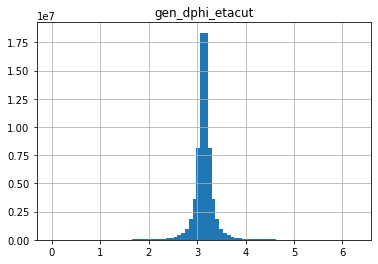

In [12]:
pandas_df_django.hist( column=['gen_dphi_etacut'], bins=80)
plt.show()

## Apply any event selection here.

In [13]:
pandas_df_rapgap = pandas_df_rapgap.query('Empz > 0')

pandas_df_rapgap = pandas_df_rapgap.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df_rapgap = pandas_df_rapgap.query('obs_hfs_pt > 0')

pandas_df_rapgap = pandas_df_rapgap.query('from_tlv_gen_Q2 > 200')

pandas_df_rapgap = pandas_df_rapgap.query('e_ecal_over_trk_ratio > 0')

#-- 2023-06-23 : remove small fraction of events that have gen_hfs_etacut_e = 0

pandas_df_rapgap = pandas_df_rapgap.query('gen_hfs_etacut_e > 0')

print('\n\n Number of entries in pandas_df_rapgap:  %d ' % pandas_df_rapgap.shape[0] )



 Number of entries in pandas_df_rapgap:  12425281 


In [14]:
pandas_df_django = pandas_df_django.query('Empz > 0')

pandas_df_django = pandas_df_django.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df_django = pandas_df_django.query('obs_hfs_pt > 0')

pandas_df_django = pandas_df_django.query('from_tlv_gen_Q2 > 200')

pandas_df_django = pandas_df_django.query('e_ecal_over_trk_ratio > 0')

#-- 2023-06-23 : remove small fraction of events that have gen_hfs_etacut_e = 0

pandas_df_django = pandas_df_django.query('gen_hfs_etacut_e > 0')

print('\n\n Number of entries in pandas_df_django:  %d ' % pandas_df_django.shape[0] )



 Number of entries in pandas_df_django:  13106282 


In [15]:
pandas_df_rapgap

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal,gen_dphi_etacut
entry,,,,,,,,,,,,,,,,,,,,,
23,0,0,24.247692,1,-0.182699,0.144760,2.422777,0.015283,0.019567,0.009369,...,43.001450,-4.329937,-1.276337,5.922210,1.071315,0.428013,True,0.060719,-0.101689,3.202085
36,0,1,13.348120,1,-1.709016,0.566964,-0.436204,0.003809,0.002255,0.004362,...,37.739708,-5.503805,-0.571310,5.453369,0.988650,2.755722,False,-0.035760,0.033116,3.166307
45,0,0,25.104801,1,-0.021559,1.420366,2.370969,0.013934,0.019074,0.008570,...,42.132053,-4.499992,-1.604122,5.424370,2.409008,3.302941,True,0.168212,-0.079415,3.160574
47,0,1,20.143602,1,0.018809,0.729400,-1.816074,0.007061,0.004471,0.008294,...,37.633305,-4.799874,-1.136600,5.592010,1.761387,2.691795,False,0.091957,0.035842,3.144557
56,1,0,32.968731,1,0.195189,0.114277,0.189013,0.092370,0.113946,0.127623,...,38.093636,-1.782004,-2.935359,6.801494,0.950580,3.264253,False,0.052082,0.024048,3.155321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61636796,0,0,26.402330,1,0.174245,0.566415,2.864766,0.024454,0.025220,0.020039,...,40.501198,-3.807051,-1.362213,6.359220,4.000000,3.087824,True,0.021586,-0.037633,3.140792
61636804,0,0,28.854366,3,1.585496,0.847493,-0.978673,0.031226,0.033230,0.085853,...,37.430954,-2.585837,-3.512525,5.430121,4.000000,3.580083,True,0.082591,0.041026,3.115176
61636805,0,0,20.172613,1,-0.271558,2.526228,-2.976105,0.007184,0.004763,0.008364,...,37.707119,-4.901348,-1.058661,5.568475,1.047844,2.608182,True,-0.055354,0.033951,3.135345


In [16]:
pandas_df_django

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal,gen_dphi_etacut
entry,,,,,,,,,,,,,,,,,,,,,
20,0,0,17.255196,1,-1.066193,0.240274,1.518299,0.004745,0.002059,0.005654,...,37.362167,-5.230584,-0.867193,5.430706,0.931784,2.221198,True,0.123451,0.042788,3.177054
22,0,0,29.893789,1,0.895007,0.601942,2.087080,0.052515,0.058272,0.067616,...,38.152119,-2.721840,-2.399088,6.407556,0.984936,2.996598,True,-0.094159,0.022550,3.175841
27,0,0,23.783131,1,-0.131410,0.446848,-1.933851,0.011714,0.016146,0.008042,...,41.864983,-4.471905,-1.468582,5.587996,1.080399,2.321987,True,0.317030,-0.072573,3.076885
33,1,0,24.646885,1,1.005825,0.120665,0.242550,0.015225,0.018389,0.011058,...,41.343658,-4.208622,-1.516757,5.799310,1.080347,1.063548,False,0.240941,-0.059217,3.212621
38,0,0,12.380091,1,-2.888133,1.764309,-0.540577,0.003480,0.003441,0.003494,...,38.996613,-5.732018,-0.448362,5.348104,0.986371,3.510371,True,-0.131654,0.000914,3.076051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70664926,0,1,31.440014,1,-0.775062,1.417537,1.238188,0.049049,0.045188,0.036317,...,41.206734,-2.930904,-1.640688,6.956891,1.049789,5.101006,False,-0.076926,-0.055709,3.030272
70664931,0,0,44.551373,1,1.560696,0.765715,1.302482,0.211871,0.188059,0.181004,...,39.628044,-1.722111,-2.139350,7.667022,0.991491,3.610188,True,-0.050591,-0.015263,3.169954
70664935,0,0,24.790230,1,0.134245,0.763465,2.130157,0.016118,0.017010,0.014791,...,39.621758,-4.290130,-1.394295,5.844058,1.270850,3.648507,True,-0.164529,-0.015102,3.160702


## Comparison of gen x, y, Q2

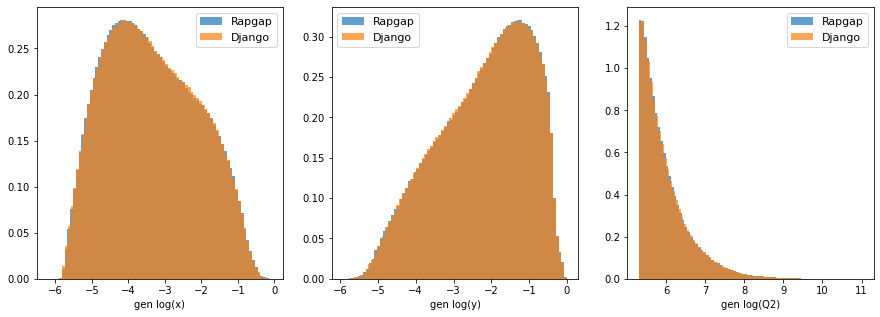

In [17]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

hbins=80
halpha=0.7

ax[0].hist( pandas_df_rapgap['gen_log_x'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[0].hist( pandas_df_django['gen_log_x'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[1].hist( pandas_df_rapgap['gen_log_y'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[1].hist( pandas_df_django['gen_log_y'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[2].hist( pandas_df_rapgap['gen_log_Q2'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[2].hist( pandas_df_django['gen_log_Q2'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )


ax[0].set_xlabel('gen log(x)')
ax[1].set_xlabel('gen log(y)')
ax[2].set_xlabel('gen log(Q2)')

ax[0].legend( loc='best', fontsize=11)
ax[1].legend( loc='best', fontsize=11)
ax[2].legend( loc='best', fontsize=11)

plt.show()

## Comparison of Rapgap and Django

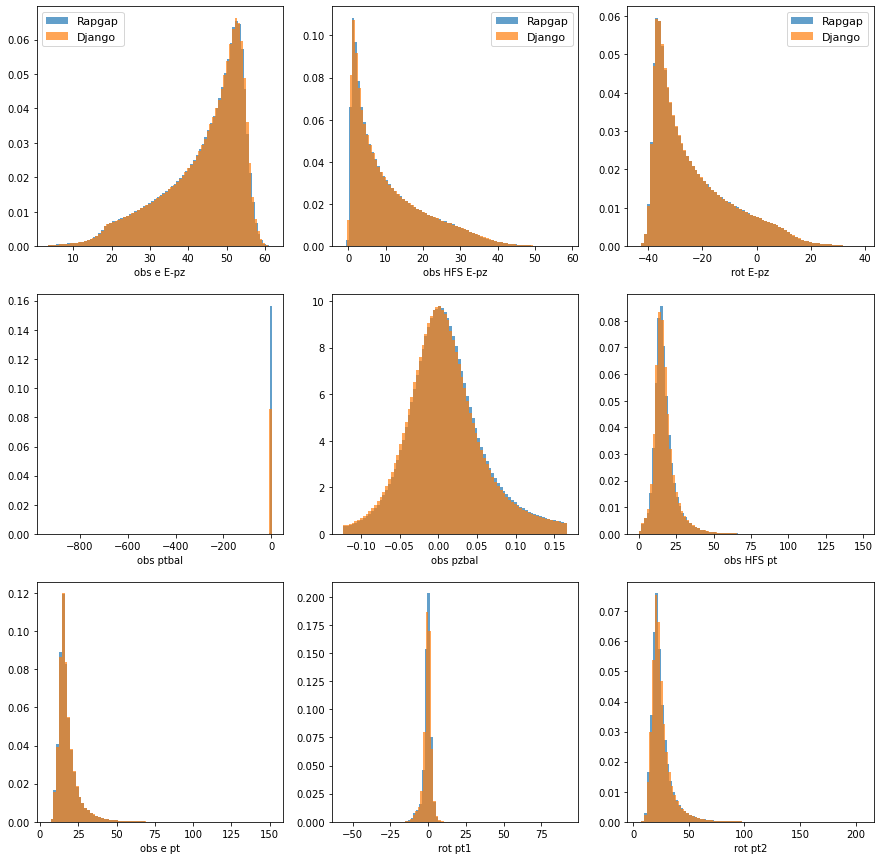

In [18]:
fig,ax = plt.subplots(3,3,figsize=(15,15))

hbins=80
halpha=0.7




ax[0][0].hist( pandas_df_rapgap['obs_e_Empz'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[0][0].hist( pandas_df_django['obs_e_Empz'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[0][1].hist( pandas_df_rapgap['obs_hfs_Empz'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[0][1].hist( pandas_df_django['obs_hfs_Empz'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[0][2].hist( pandas_df_rapgap['rot_Empz1'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[0][2].hist( pandas_df_django['rot_Empz1'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )




ax[1][0].hist( pandas_df_rapgap['obs_ptbal'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[1][0].hist( pandas_df_django['obs_ptbal'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[1][1].hist( pandas_df_rapgap['obs_pzbal'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[1][1].hist( pandas_df_django['obs_pzbal'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[1][2].hist( pandas_df_rapgap['obs_hfs_pt'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[1][2].hist( pandas_df_django['obs_hfs_pt'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )






ax[2][0].hist( pandas_df_rapgap['obs_e_pt'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[2][0].hist( pandas_df_django['obs_e_pt'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[2][1].hist( pandas_df_rapgap['rot_pt1'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[2][1].hist( pandas_df_django['rot_pt1'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[2][2].hist( pandas_df_rapgap['rot_pt2'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[2][2].hist( pandas_df_django['rot_pt2'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )







ax[0][0].set_xlabel('obs e E-pz')
ax[0][1].set_xlabel('obs HFS E-pz')
ax[0][2].set_xlabel('rot E-pz')

ax[1][0].set_xlabel('obs ptbal')
ax[1][1].set_xlabel('obs pzbal')
ax[1][2].set_xlabel('obs HFS pt')

ax[2][0].set_xlabel('obs e pt')
ax[2][1].set_xlabel('rot pt1')
ax[2][2].set_xlabel('rot pt2')




ax[0][0].legend( loc='best', fontsize=11)
ax[0][1].legend( loc='best', fontsize=11)
ax[0][2].legend( loc='best', fontsize=11)

plt.show()

## Rapgap, comparison of detector and particle (obs and gen)

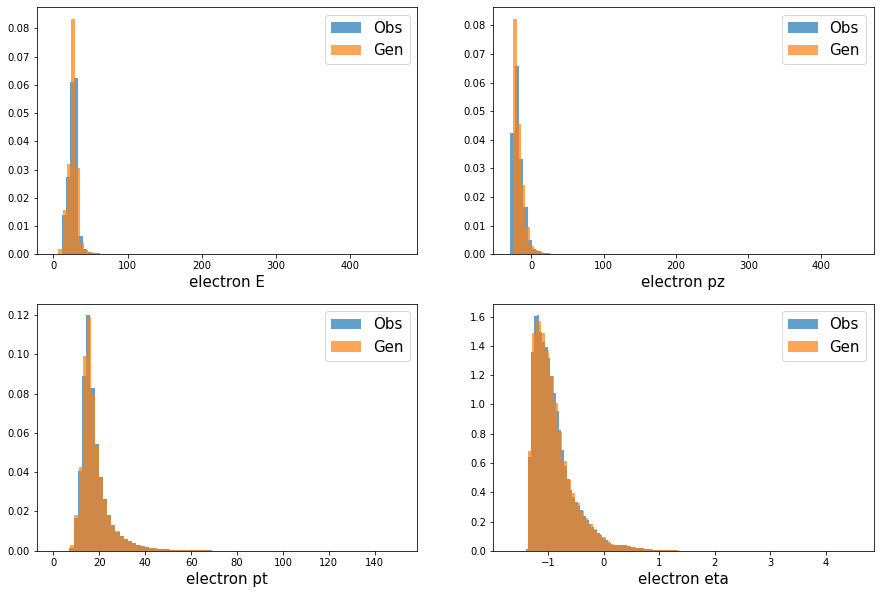

In [19]:
fig,ax = plt.subplots(2,2,figsize=(15,10))

hbins=80
halpha=0.7




ax[0][0].hist( pandas_df_rapgap['obs_e_e'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[0][0].hist( pandas_df_rapgap['gen_e_e'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[0][1].hist( pandas_df_rapgap['obs_e_pz'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[0][1].hist( pandas_df_rapgap['gen_e_pz'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[1][0].hist( pandas_df_rapgap['obs_e_pt'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[1][0].hist( pandas_df_rapgap['gen_e_pt'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[1][1].hist( pandas_df_rapgap['obs_e_eta'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[1][1].hist( pandas_df_rapgap['gen_e_eta'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )


hfontsize=15

ax[0][0].set_xlabel('electron E', fontsize=hfontsize)
ax[0][1].set_xlabel('electron pz', fontsize=hfontsize)

ax[1][0].set_xlabel('electron pt', fontsize=hfontsize)
ax[1][1].set_xlabel('electron eta', fontsize=hfontsize)

ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)

ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)





plt.show()

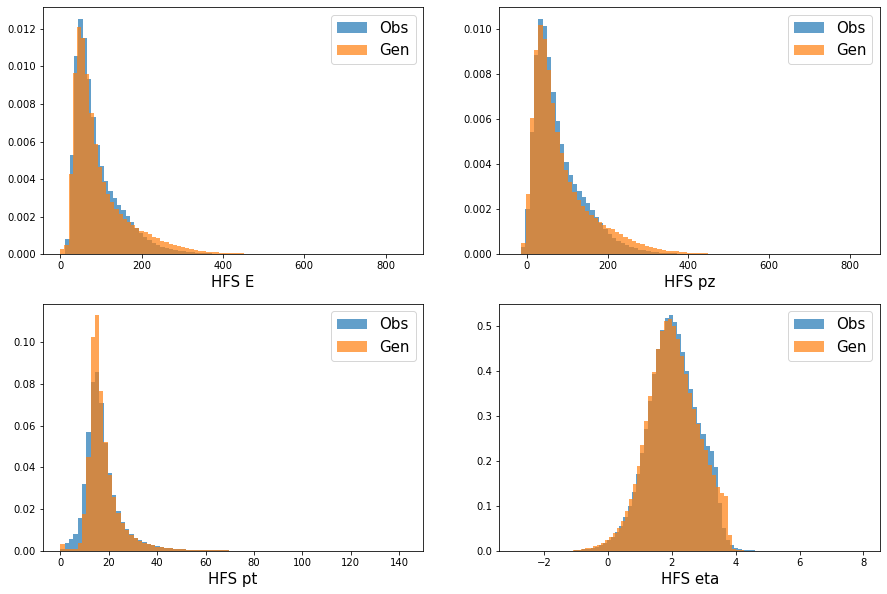

In [20]:
fig,ax = plt.subplots(2,2,figsize=(15,10))

hbins=80
halpha=0.7




ax[0][0].hist( pandas_df_rapgap['obs_hfs_e'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[0][0].hist( pandas_df_rapgap['gen_hfs_etacut_e'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[0][1].hist( pandas_df_rapgap['obs_hfs_pz'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[0][1].hist( pandas_df_rapgap['gen_hfs_etacut_pz'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[1][0].hist( pandas_df_rapgap['obs_hfs_pt'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[1][0].hist( pandas_df_rapgap['gen_hfs_etacut_pt'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[1][1].hist( pandas_df_rapgap['obs_hfs_eta'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[1][1].hist( pandas_df_rapgap['gen_hfs_etacut_eta'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

hfontsize=15

ax[0][0].set_xlabel('HFS E', fontsize=hfontsize)
ax[0][1].set_xlabel('HFS pz', fontsize=hfontsize)

ax[1][0].set_xlabel('HFS pt', fontsize=hfontsize)
ax[1][1].set_xlabel('HFS eta', fontsize=hfontsize)

ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)

ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)



plt.show()

## Look at the distribution of event weights.

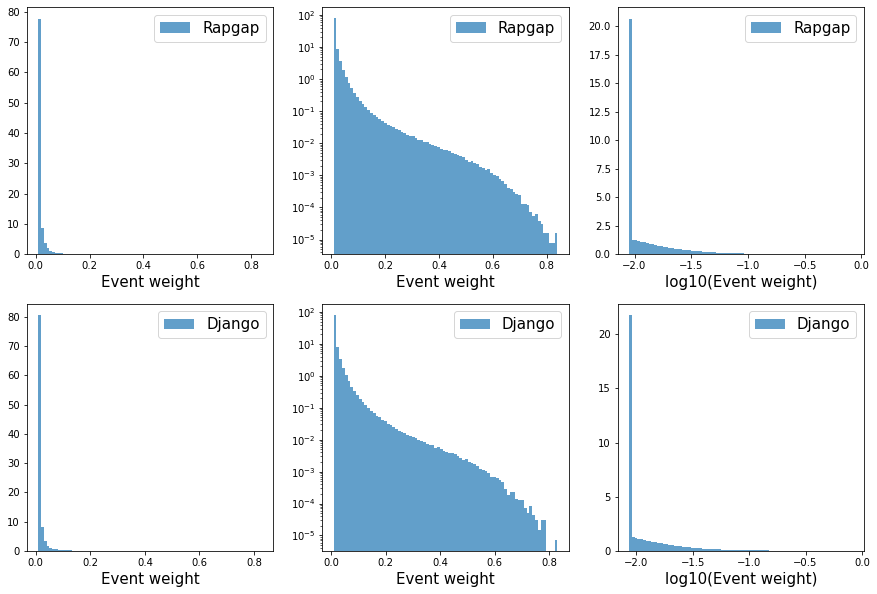

In [21]:
fig,ax = plt.subplots(2,3,figsize=(15,10))

ax[0][0].hist( pandas_df_rapgap['wgt'], density=True, bins=hbins, alpha=halpha, label='Rapgap' )
ax[0][1].hist( pandas_df_rapgap['wgt'], density=True, bins=hbins, alpha=halpha, label='Rapgap' )
ax[0][2].hist( np.log10(pandas_df_rapgap['wgt']), density=True, bins=hbins, alpha=halpha, label='Rapgap' )

#ax[0][2].hist( np.log10(pandas_df_rapgap.query('wgt>0.01')['wgt']), density=True, bins=hbins, alpha=halpha, label='Rapgap' )



ax[1][0].hist( pandas_df_django['wgt'], density=True, bins=hbins, alpha=halpha, label='Django' )
ax[1][1].hist( pandas_df_django['wgt'], density=True, bins=hbins, alpha=halpha, label='Django' )
ax[1][2].hist( np.log10(pandas_df_django['wgt']), density=True, bins=hbins, alpha=halpha, label='Django' )

#ax[1][2].hist( np.log10(pandas_df_django.query('wgt>0.01')['wgt']), density=True, bins=hbins, alpha=halpha, label='Django' )



ax[0][1].set_yscale('log')
ax[1][1].set_yscale('log')

hfontsize=15

ax[0][0].legend( loc='best', fontsize=hfontsize )
ax[1][0].legend( loc='best', fontsize=hfontsize )

ax[0][1].legend( loc='best', fontsize=hfontsize )
ax[1][1].legend( loc='best', fontsize=hfontsize )

ax[0][2].legend( loc='best', fontsize=hfontsize )
ax[1][2].legend( loc='best', fontsize=hfontsize )


ax[0][0].set_xlabel('Event weight', fontsize=hfontsize)
ax[0][1].set_xlabel('Event weight', fontsize=hfontsize)
ax[0][2].set_xlabel('log10(Event weight)', fontsize=hfontsize)

ax[1][0].set_xlabel('Event weight', fontsize=hfontsize)
ax[1][1].set_xlabel('Event weight', fontsize=hfontsize)
ax[1][2].set_xlabel('log10(Event weight)', fontsize=hfontsize)


plt.show()

## Set up machine learning stuff

In [22]:
X_gen_r = np.c_[
    pandas_df_rapgap['gen_e_e'].to_numpy(),
    pandas_df_rapgap['gen_e_pz'].to_numpy(),
    pandas_df_rapgap['gen_e_pt'].to_numpy(),
    pandas_df_rapgap['gen_e_eta'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_rapgap['gen_dphi_etacut'].to_numpy(),
]

X_obs_r = np.c_[
    pandas_df_rapgap['obs_e_e'].to_numpy(),
    pandas_df_rapgap['obs_e_pz'].to_numpy(),
    pandas_df_rapgap['obs_e_pt'].to_numpy(),
    pandas_df_rapgap['obs_e_eta'].to_numpy(),
    pandas_df_rapgap['obs_hfs_e'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pz'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pt'].to_numpy(),
    pandas_df_rapgap['obs_hfs_eta'].to_numpy(),
    pandas_df_rapgap['obs_dphi'].to_numpy(),
]


w_r = np.c_[
    pandas_df_rapgap['wgt'].to_numpy(),
]

Y_r = np.c_[
    np.ones(len(pandas_df_rapgap))
]

In [23]:
print(" shapes:  X_gen_r = %s , X_obs_r = %s , w_r = %s , Y_r = %s" % ( str(np.shape(X_gen_r)), str(np.shape(X_obs_r)), str(np.shape(w_r)), str(np.shape(Y_r)) ) )


 shapes:  X_gen_r = (12425281, 9) , X_obs_r = (12425281, 9) , w_r = (12425281, 1) , Y_r = (12425281, 1)


In [24]:
X_gen_d = np.c_[
    pandas_df_django['gen_e_e'].to_numpy(),
    pandas_df_django['gen_e_pz'].to_numpy(),
    pandas_df_django['gen_e_pt'].to_numpy(),
    pandas_df_django['gen_e_eta'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_django['gen_dphi_etacut'].to_numpy(),
]

X_obs_d = np.c_[
    pandas_df_django['obs_e_e'].to_numpy(),
    pandas_df_django['obs_e_pz'].to_numpy(),
    pandas_df_django['obs_e_pt'].to_numpy(),
    pandas_df_django['obs_e_eta'].to_numpy(),
    pandas_df_django['obs_hfs_e'].to_numpy(),
    pandas_df_django['obs_hfs_pz'].to_numpy(),
    pandas_df_django['obs_hfs_pt'].to_numpy(),
    pandas_df_django['obs_hfs_eta'].to_numpy(),
    pandas_df_django['obs_dphi'].to_numpy(),
]




w_d = np.c_[
    pandas_df_django['wgt'].to_numpy(),
]

Y_d = np.c_[
    np.zeros(len(pandas_df_django))
]


In [25]:
print(" shapes:  X_gen_d = %s , X_obs_d = %s , w_d = %s , Y_d = %s" % ( str(np.shape(X_gen_d)), str(np.shape(X_obs_d)), str(np.shape(w_d)), str(np.shape(Y_d)) ) )

 shapes:  X_gen_d = (13106282, 9) , X_obs_d = (13106282, 9) , w_d = (13106282, 1) , Y_d = (13106282, 1)


In [26]:
X_gen = np.concatenate( [X_gen_r, X_gen_d] )
X_obs = np.concatenate( [X_obs_r, X_obs_d] )
w = np.concatenate( [w_r, w_d])
Y = np.concatenate( [Y_r, Y_d])

In [27]:
print(" shapes:  X_gen = %s , X_obs = %s ,  w = %s , Y = %s" % ( str(np.shape(X_gen)),  str(np.shape(X_obs)), str(np.shape(w)), str(np.shape(Y)) ) )

 shapes:  X_gen = (25531563, 9) , X_obs = (25531563, 9) ,  w = (25531563, 1) , Y = (25531563, 1)


In [28]:
X_gen

array([[ 23.27876663, -16.51725578,  16.40369606, ...,  16.67554092,
          1.93788922,   3.20208526],
       [ 13.49057484,  -9.36167717,   9.71362972, ...,   9.75612164,
          2.02149129,   3.16630697],
       [ 24.10554504, -19.99560928,  13.46301937, ...,  13.40249443,
          1.97886217,   3.16057396],
       ...,
       [ 23.8815918 , -17.62838364,  16.1111927 , ...,  14.34417915,
          1.27882421,   3.16070175],
       [ 26.92986298, -17.62105179,  20.36457825, ...,  20.5132103 ,
          1.33482373,   3.12465096],
       [ 21.47595024,  -2.14906526,  21.36815262, ...,  21.42353821,
         -0.10853604,   3.09816861]])

In [29]:
X_obs

array([[ 24.247692 , -17.285646 ,  17.004618 , ...,  18.103865 ,
          2.3029   ,   3.2084012],
       [ 13.34812  ,  -9.203184 ,   9.6681795, ...,   9.334386 ,
          2.4759128,   3.1380625],
       [ 25.104801 , -20.77686  ,  14.091598 , ...,  16.941334 ,
          1.0790696,   3.1579218],
       ...,
       [ 24.79023  , -18.26551  ,  16.760866 , ...,  14.392831 ,
          1.3969289,   3.2558293],
       [ 26.36385  , -17.452839 ,  19.759832 , ...,  18.739016 ,
          1.8715216,   3.0673265],
       [ 21.3188   ,  -2.2810602,  21.196415 , ...,  25.697718 ,
          1.2280906,   3.0874186]], dtype=float32)

In [30]:

scaler_file = "%s/input-scaler-gen-only.pkl" % output_dir

if run_training :
    print("Creating new scaler.")
    scalerX = StandardScaler()
    scalerX.fit(X_gen)
else :
    print("Reading scaler from file: %s" % scaler_file )
    scalerX = load( open(scaler_file, 'rb') )
    
Xs_gen = scalerX.transform(X_gen)
Xs_obs = scalerX.transform(X_obs)

if run_training :
    print("Saving scaler to %s" % scaler_file)
    dump( scalerX, open(scaler_file, 'wb'))


Creating new scaler.
Saving scaler to version5a-lambda1.00-no-weights-training-output/input-scaler-gen-only.pkl


In [31]:
X_gen_train, X_gen_test, X_obs_train, X_obs_test, Y_train, Y_test, w_train, w_test = train_test_split( Xs_gen, Xs_obs, Y, w, test_size=0.5 )

In [32]:
print("\n shapes:  X_gen_train = %s , X_obs_train = %s" % ( str(np.shape(X_gen_train)), str(np.shape(X_obs_train))))


 shapes:  X_gen_train = (12765781, 9) , X_obs_train = (12765781, 9)


In [33]:
Xs_so_gen_d = scalerX.transform( X_gen_d )
Xs_so_obs_d = scalerX.transform( X_obs_d )
Xs_so_gen_r = scalerX.transform( X_gen_r )
Xs_so_obs_r = scalerX.transform( X_obs_r )

## Comparison of gen with obs (particle with detector) , without event weights

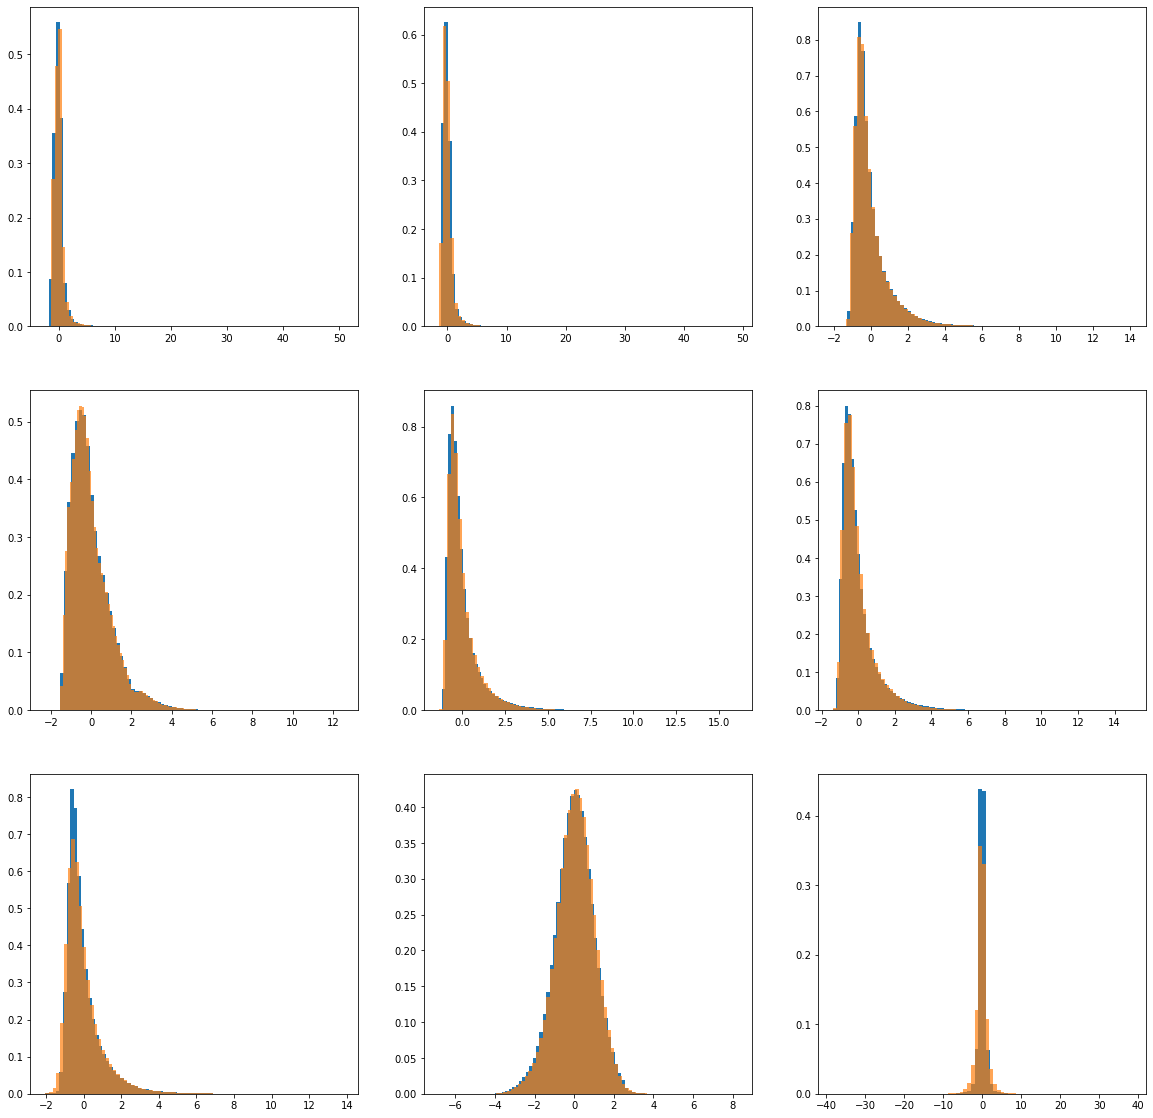

In [34]:
fig,ax = plt.subplots(3,3,figsize=(20,20))

hbins = 80


ax[0][0].hist( Xs_gen[:,0], density=True, bins=hbins )
ax[0][1].hist( Xs_gen[:,1], density=True, bins=hbins )
ax[0][2].hist( Xs_gen[:,2], density=True, bins=hbins )

ax[1][0].hist( Xs_gen[:,3], density=True, bins=hbins )
ax[1][1].hist( Xs_gen[:,4], density=True, bins=hbins )
ax[1][2].hist( Xs_gen[:,5], density=True, bins=hbins )

ax[2][0].hist( Xs_gen[:,6], density=True, bins=hbins )
ax[2][1].hist( Xs_gen[:,7], density=True, bins=hbins )
ax[2][2].hist( Xs_gen[:,8], density=True, bins=hbins )



ax[0][0].hist( Xs_obs[:,0], density=True, bins=hbins, alpha=0.7 )
ax[0][1].hist( Xs_obs[:,1], density=True, bins=hbins, alpha=0.7 )
ax[0][2].hist( Xs_obs[:,2], density=True, bins=hbins, alpha=0.7 )

ax[1][0].hist( Xs_obs[:,3], density=True, bins=hbins, alpha=0.7 )
ax[1][1].hist( Xs_obs[:,4], density=True, bins=hbins, alpha=0.7 )
ax[1][2].hist( Xs_obs[:,5], density=True, bins=hbins , alpha=0.7)

ax[2][0].hist( Xs_obs[:,6], density=True, bins=hbins, alpha=0.7 )
ax[2][1].hist( Xs_obs[:,7], density=True, bins=hbins , alpha=0.7)
ax[2][2].hist( Xs_obs[:,8], density=True, bins=hbins, alpha=0.7 )



plt.show()

## Comparison of gen with obs (particle with detector) , including event weights

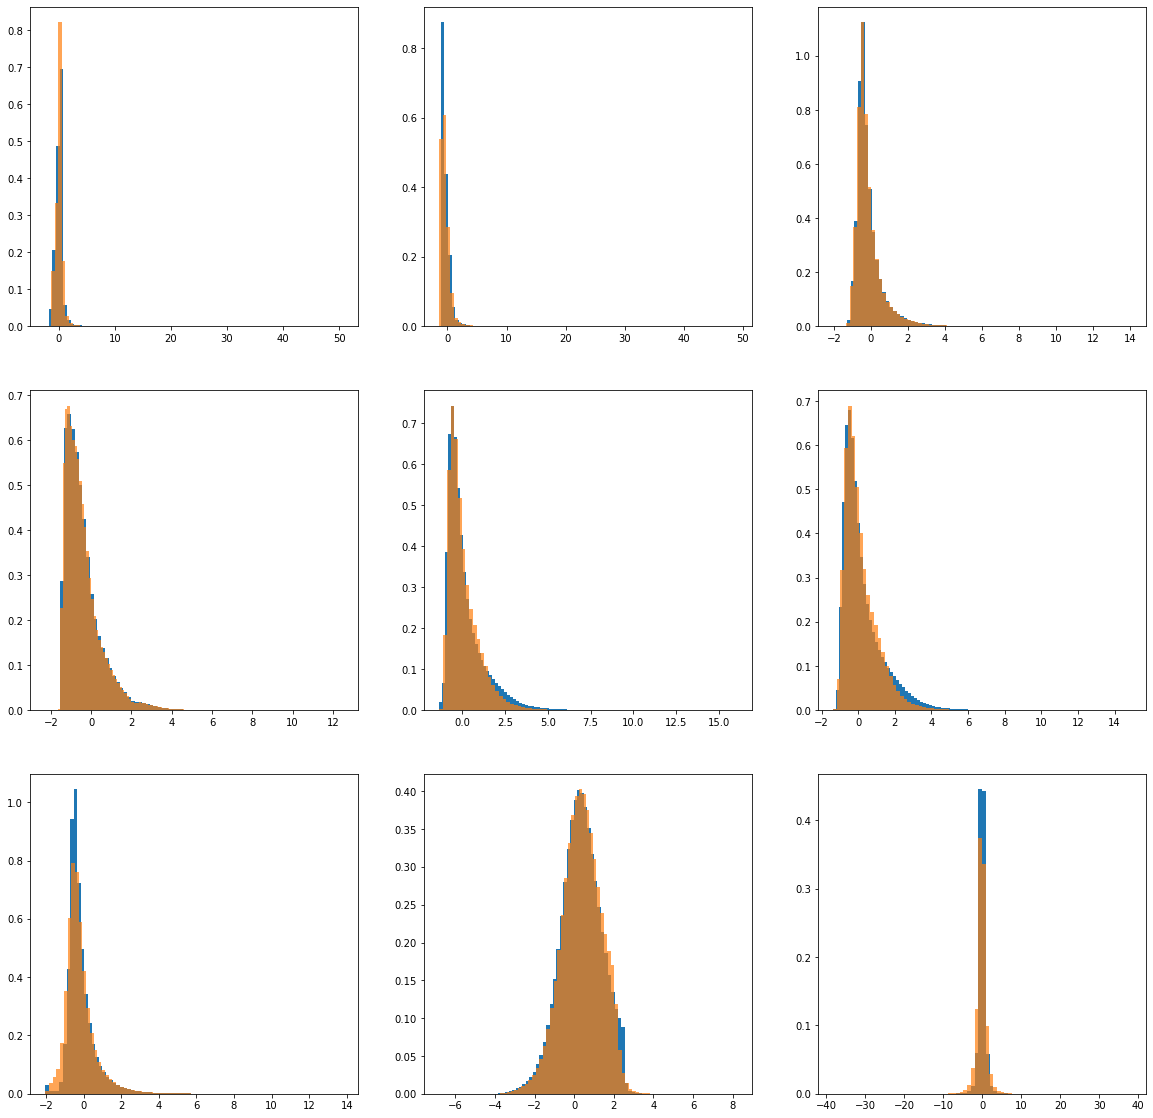

In [35]:
fig,ax = plt.subplots(3,3,figsize=(20,20))

hbins = 80


ax[0][0].hist( Xs_gen[:,0], density=True, bins=hbins, weights=w )
ax[0][1].hist( Xs_gen[:,1], density=True, bins=hbins, weights=w )
ax[0][2].hist( Xs_gen[:,2], density=True, bins=hbins, weights=w )

ax[1][0].hist( Xs_gen[:,3], density=True, bins=hbins, weights=w )
ax[1][1].hist( Xs_gen[:,4], density=True, bins=hbins, weights=w )
ax[1][2].hist( Xs_gen[:,5], density=True, bins=hbins, weights=w )

ax[2][0].hist( Xs_gen[:,6], density=True, bins=hbins, weights=w )
ax[2][1].hist( Xs_gen[:,7], density=True, bins=hbins, weights=w )
ax[2][2].hist( Xs_gen[:,8], density=True, bins=hbins, weights=w )



ax[0][0].hist( Xs_obs[:,0], density=True, bins=hbins, alpha=0.7, weights=w )
ax[0][1].hist( Xs_obs[:,1], density=True, bins=hbins, alpha=0.7, weights=w )
ax[0][2].hist( Xs_obs[:,2], density=True, bins=hbins, alpha=0.7, weights=w )

ax[1][0].hist( Xs_obs[:,3], density=True, bins=hbins, alpha=0.7, weights=w )
ax[1][1].hist( Xs_obs[:,4], density=True, bins=hbins, alpha=0.7, weights=w )
ax[1][2].hist( Xs_obs[:,5], density=True, bins=hbins, alpha=0.7, weights=w )

ax[2][0].hist( Xs_obs[:,6], density=True, bins=hbins, alpha=0.7, weights=w )
ax[2][1].hist( Xs_obs[:,7], density=True, bins=hbins, alpha=0.7, weights=w )
ax[2][2].hist( Xs_obs[:,8], density=True, bins=hbins, alpha=0.7, weights=w )



plt.show()

In [36]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    return K.mean(t_loss)

def weighted_mse(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    return K.mean(weights*(y_true - y_pred)**2)

## Simple classifier (Django vs Rapgap), using only detector-level features

In [37]:
simple_model = Sequential()
simple_model.add(Dense(50, input_dim=9, activation='relu')) 
simple_model.add(Dense(50, activation='relu'))
simple_model.add(Dense(1, activation='sigmoid'))

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )

if use_weights :

    print("\n\n Including weighted_metrics in compile.\n\n")
    
    simple_model.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'], 
                      weighted_metrics=['accuracy'])
    
else :
        
    simple_model.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
        
        
        

2023-07-05 16:08:26.427772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 16:08:26.428029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 16:08:26.428204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 16:08:26.428420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 16:08:26.428596: I tensorflow/compiler/xla/stream_executo

In [38]:
#model = Sequential()
#model.add(Dense(150, input_dim=9, activation='relu')) 
#model.add(Dense(350, activation='relu'))
#model.add(Dense(150, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
#model = Sequential()
#model.add(Dense(150, input_dim=9, activation='relu')) 
#model.add(Dense(350, activation='relu'))
#model.add(Dense(350, activation='relu'))
#model.add(Dense(150, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
#model = Sequential()
#model.add(Dense(150, input_dim=9, activation='relu')) 
#model.add(Dense(350, activation='relu'))
#model.add(Dense(650, activation='relu'))
#model.add(Dense(350, activation='relu'))
#model.add(Dense(150, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
#model = Sequential()
#model.add(Dense(150, input_dim=9, activation='relu')) 
#model.add(Dense(350, activation='relu'))
#model.add(Dense(550, activation='relu'))
#model.add(Dense(850, activation='relu'))
#model.add(Dense(350, activation='relu'))
#model.add(Dense(150, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=20,
               verbose=True,
               restore_best_weights=True)

In [43]:
%%time


if run_training :
    
    if use_weights :

        print("\n\n Training with weights.\n\n")
        
        hist = simple_model.fit(X_obs_train, Y_train, validation_data=(X_obs_test, Y_test, w_test), epochs=max_epochs, 
                 batch_size=batch_size_setval,
                 sample_weight=w_train,
                 verbose = 1, callbacks=[earlystopping] )

  

    else :
        
        hist = simple_model.fit(X_obs_train, Y_train, validation_data=(X_obs_test, Y_test), epochs=max_epochs, 
                 batch_size=batch_size_setval,
                 verbose = 1, callbacks=[earlystopping] )        


Epoch 1/5000


2023-07-05 16:08:28.497257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-05 16:08:28.500281: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f24bc0199b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-05 16:08:28.500303: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-07-05 16:08:28.506897: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-05 16:08:28.618702: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24934/24934 [==============================] - 85s 3ms/step - loss: 0.6748 - accuracy: 0.5816 - val_loss: 0.6733 - val_accuracy: 0.5839
Epoch 2/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6729 - accuracy: 0.5843 - val_loss: 0.6727 - val_accuracy: 0.5846
Epoch 3/5000
24934/24934 [==============================] - 83s 3ms/step - loss: 0.6726 - accuracy: 0.5848 - val_loss: 0.6725 - val_accuracy: 0.5849
Epoch 4/5000
24934/24934 [==============================] - 83s 3ms/step - loss: 0.6724 - accuracy: 0.5850 - val_loss: 0.6724 - val_accuracy: 0.5852
Epoch 5/5000
24934/24934 [==============================] - 83s 3ms/step - loss: 0.6722 - accuracy: 0.5852 - val_loss: 0.6722 - val_accuracy: 0.5852
Epoch 6/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6721 - accuracy: 0.5853 - val_loss: 0.6722 - val_accuracy: 0.5853
Epoch 7/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6720 - accuracy: 0.5855 - val_loss: 

Epoch 56/5000
24934/24934 [==============================] - 83s 3ms/step - loss: 0.6708 - accuracy: 0.5873 - val_loss: 0.6710 - val_accuracy: 0.5870
Epoch 57/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6708 - accuracy: 0.5873 - val_loss: 0.6710 - val_accuracy: 0.5870
Epoch 58/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6708 - accuracy: 0.5873 - val_loss: 0.6710 - val_accuracy: 0.5869
Epoch 59/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6708 - accuracy: 0.5872 - val_loss: 0.6710 - val_accuracy: 0.5871
Epoch 60/5000
24934/24934 [==============================] - 83s 3ms/step - loss: 0.6708 - accuracy: 0.5874 - val_loss: 0.6710 - val_accuracy: 0.5870
Epoch 61/5000
24934/24934 [==============================] - 83s 3ms/step - loss: 0.6708 - accuracy: 0.5873 - val_loss: 0.6709 - val_accuracy: 0.5871
Epoch 62/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6708 - accuracy:

24934/24934 [==============================] - 82s 3ms/step - loss: 0.6705 - accuracy: 0.5878 - val_loss: 0.6707 - val_accuracy: 0.5875
Epoch 111/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6705 - accuracy: 0.5877 - val_loss: 0.6707 - val_accuracy: 0.5875
Epoch 112/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6705 - accuracy: 0.5878 - val_loss: 0.6707 - val_accuracy: 0.5875
Epoch 113/5000
24934/24934 [==============================] - 83s 3ms/step - loss: 0.6705 - accuracy: 0.5878 - val_loss: 0.6707 - val_accuracy: 0.5875
Epoch 114/5000
24934/24934 [==============================] - 81s 3ms/step - loss: 0.6705 - accuracy: 0.5878 - val_loss: 0.6708 - val_accuracy: 0.5874
Epoch 115/5000
24934/24934 [==============================] - 81s 3ms/step - loss: 0.6705 - accuracy: 0.5878 - val_loss: 0.6707 - val_accuracy: 0.5874
Epoch 116/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6705 - accuracy: 0.5878 

24934/24934 [==============================] - 82s 3ms/step - loss: 0.6704 - accuracy: 0.5880 - val_loss: 0.6706 - val_accuracy: 0.5877
Epoch 165/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6704 - accuracy: 0.5880 - val_loss: 0.6707 - val_accuracy: 0.5876
Epoch 166/5000
24934/24934 [==============================] - 83s 3ms/step - loss: 0.6704 - accuracy: 0.5880 - val_loss: 0.6707 - val_accuracy: 0.5876
Epoch 167/5000
24934/24934 [==============================] - 80s 3ms/step - loss: 0.6704 - accuracy: 0.5880 - val_loss: 0.6707 - val_accuracy: 0.5876
Epoch 168/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6704 - accuracy: 0.5880 - val_loss: 0.6706 - val_accuracy: 0.5876
Epoch 169/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6704 - accuracy: 0.5880 - val_loss: 0.6706 - val_accuracy: 0.5877
Epoch 170/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6704 - accuracy: 0.5880 

24934/24934 [==============================] - 82s 3ms/step - loss: 0.6704 - accuracy: 0.5880 - val_loss: 0.6705 - val_accuracy: 0.5877
Epoch 219/5000
24934/24934 [==============================] - 79s 3ms/step - loss: 0.6703 - accuracy: 0.5881 - val_loss: 0.6706 - val_accuracy: 0.5877
Epoch 220/5000
24934/24934 [==============================] - 82s 3ms/step - loss: 0.6703 - accuracy: 0.5881 - val_loss: 0.6706 - val_accuracy: 0.5876
Epoch 221/5000
24934/24934 [==============================] - 83s 3ms/step - loss: 0.6703 - accuracy: 0.5881 - val_loss: 0.6706 - val_accuracy: 0.5877
Epoch 222/5000
24934/24934 [==============================] - 81s 3ms/step - loss: 0.6703 - accuracy: 0.5881 - val_loss: 0.6705 - val_accuracy: 0.5878
Epoch 223/5000
24934/24934 [==============================] - 80s 3ms/step - loss: 0.6703 - accuracy: 0.5881 - val_loss: 0.6706 - val_accuracy: 0.5877
Epoch 224/5000
24934/24934 [==============================] - 83s 3ms/step - loss: 0.6703 - accuracy: 0.5881 

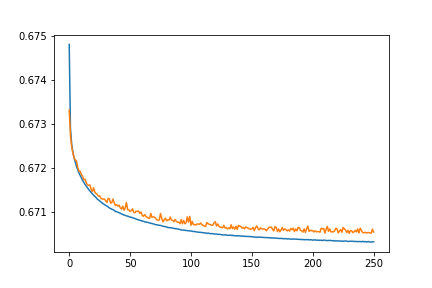

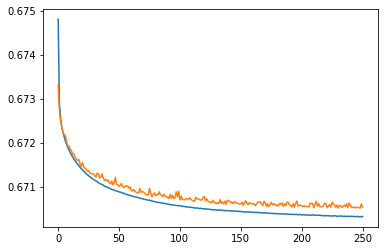

In [44]:
if run_training :
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.savefig('%s/loss-vs-epoch-simple-classifier-gen-inputs.pdf' % output_dir )
    plt.savefig('%s/loss-vs-epoch-simple-classifier-gen-inputs.png' % output_dir )

display.Image('%s/loss-vs-epoch-simple-classifier-gen-inputs.png' % output_dir )

In [45]:

if run_training :
    tf.keras.models.save_model( simple_model, '%s/model-simple-classifier-gen-inputs' % output_dir )
else :
    simple_model = tf.keras.models.load_model( '%s/model-simple-classifier-gen-inputs' % output_dir )
    

INFO:tensorflow:Assets written to: version5a-lambda1.00-no-weights-training-output/model-simple-classifier-gen-inputs/assets


In [46]:
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                500       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,101
Trainable params: 3,101
Non-trainable params: 0
_________________________________________________________________


In [47]:
simple_classifier_output_gen = simple_model.predict( X_gen_test, batch_size=1024)
simple_classifier_output_obs = simple_model.predict( X_obs_test, batch_size=1024)

12467/12467 [==============================] - 7s 576us/step


In [48]:
simple_classifier_output_django_gen = simple_model.predict( Xs_so_gen_d, batch_size=2048 )
simple_classifier_output_django_obs = simple_model.predict( Xs_so_obs_d, batch_size=2048 )
simple_classifier_output_rapgap_gen = simple_model.predict( Xs_so_gen_r, batch_size=2048 )
simple_classifier_output_rapgap_obs = simple_model.predict( Xs_so_obs_r, batch_size=2048 )

6068/6068 [==============================] - 4s 571us/step


Turning off weights.


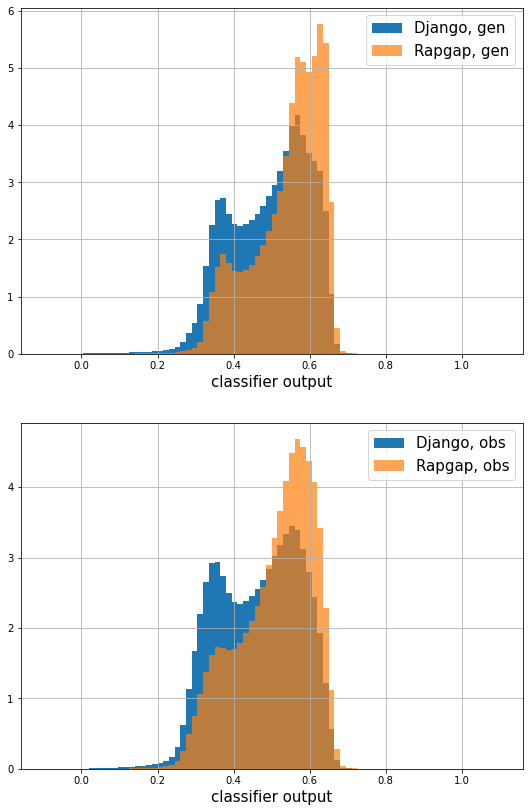

In [49]:
fig,ax = plt.subplots(2,1,figsize=(9,14))

hweights = w_test

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights.fill(1)



hist0 = ax[0].hist( simple_classifier_output_gen[Y_test==0], weights=hweights[Y_test==0], 
                   density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
hist1 = ax[0].hist( simple_classifier_output_gen[Y_test==1], weights=hweights[Y_test==1], 
                   density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen', alpha=0.7)

hist0_obs = ax[1].hist( simple_classifier_output_obs[Y_test==0], weights=hweights[Y_test==0], 
                       density=True, bins=80, range=[-0.1,1.1], label='Django, obs')
hist1_obs = ax[1].hist( simple_classifier_output_obs[Y_test==1], weights=hweights[Y_test==1], 
                       density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7)

ax[0].grid()
ax[1].grid()


hfontsize=15

ax[0].set_xlabel('classifier output', fontsize=hfontsize)
ax[1].set_xlabel('classifier output', fontsize=hfontsize)



ax[0].legend( loc='best', fontsize=hfontsize)
ax[1].legend( loc='best', fontsize=hfontsize)

plt.show()

Turning off weights.


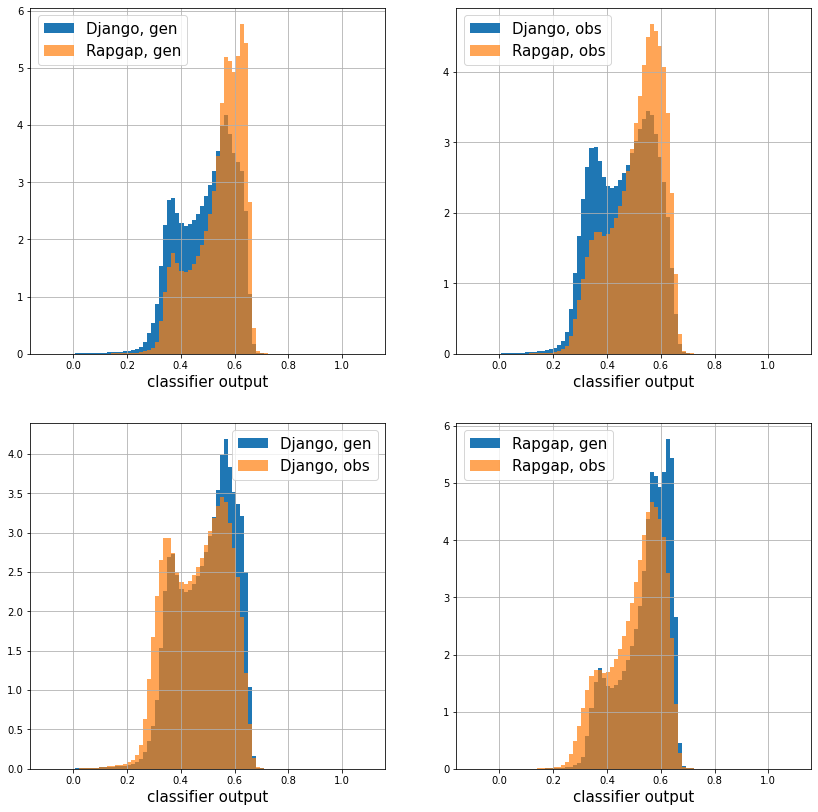

In [50]:
fig,ax = plt.subplots(2,2,figsize=(14,14))

hweights_r = w_r
hweights_d = w_d

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights_r.fill(1)
    hweights_d.fill(1)

ax[0][0].hist( simple_classifier_output_django_gen, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[0][0].hist( simple_classifier_output_rapgap_gen, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen', alpha=0.7)
      
ax[0][1].hist( simple_classifier_output_django_obs, weights=hweights_d, 
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs' )
ax[0][1].hist( simple_classifier_output_rapgap_obs, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7)

ax[1][0].hist( simple_classifier_output_django_gen, weights=hweights_d, 
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[1][0].hist( simple_classifier_output_django_obs, weights=hweights_d, 
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs', alpha=0.7 )


ax[1][1].hist( simple_classifier_output_rapgap_gen, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen' )
ax[1][1].hist( simple_classifier_output_rapgap_obs, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7 )




ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()



hfontsize=15

ax[0][0].set_xlabel('classifier output', fontsize=hfontsize)
ax[1][0].set_xlabel('classifier output', fontsize=hfontsize)
ax[0][1].set_xlabel('classifier output', fontsize=hfontsize)
ax[1][1].set_xlabel('classifier output', fontsize=hfontsize)



ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)


plt.show()

Turning off weights.


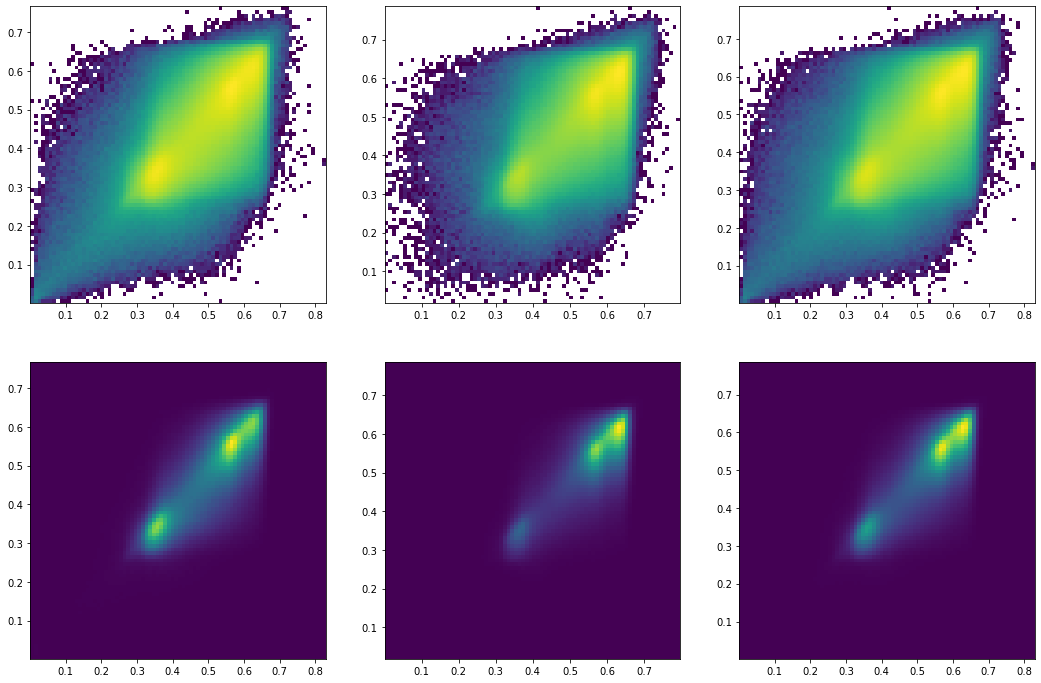

In [51]:
fig,ax = plt.subplots(2,3,figsize=(18,12))

hweights = w_test

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights.fill(1)



ax[0][0].hist2d( simple_classifier_output_gen[Y_test==0], 
                simple_classifier_output_obs[Y_test==0], 
                weights=hweights[Y_test==0],
                bins=80, norm=mpl.colors.LogNorm())
ax[0][1].hist2d( simple_classifier_output_gen[Y_test==1], 
                simple_classifier_output_obs[Y_test==1], 
                weights=hweights[Y_test==1], 
                bins=80, norm=mpl.colors.LogNorm())
ax[0][2].hist2d( simple_classifier_output_gen[Y_test>-1], 
                simple_classifier_output_obs[Y_test>-1], 
                weights=hweights[Y_test>-1], 
                bins=80, norm=mpl.colors.LogNorm())

ax[1][0].hist2d( simple_classifier_output_gen[Y_test==0], 
                simple_classifier_output_obs[Y_test==0], 
                weights=hweights[Y_test==0], 
                bins=80)
ax[1][1].hist2d( simple_classifier_output_gen[Y_test==1], 
                simple_classifier_output_obs[Y_test==1], 
                weights=hweights[Y_test==1], 
                bins=80)
ax[1][2].hist2d( simple_classifier_output_gen[Y_test>-1], 
                simple_classifier_output_obs[Y_test>-1], 
                weights=hweights[Y_test>-1], 
                bins=80)


plt.show()

In [52]:
from sklearn.metrics import roc_curve, auc,roc_auc_score

In [53]:
if use_weights :
    simple_fpr, simple_tpr, _ = roc_curve( Y_test, simple_classifier_output_obs, sample_weight=w_test)
else :
    simple_fpr, simple_tpr, _ = roc_curve( Y_test, simple_classifier_output_obs)

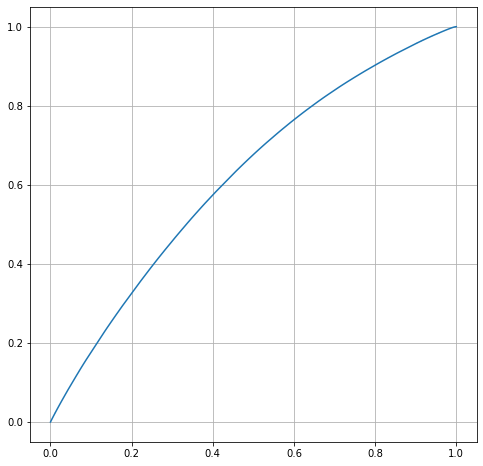

In [54]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
plt.plot( simple_fpr, simple_tpr)
plt.grid()
plt.show()

In [55]:
total0 = sum(hist0[0])
total1 = sum(hist1[0])

npoints = len(hist0[0])
print('Number of points: %d' % npoints)

fr0 = np.zeros(npoints)
fr1 = np.zeros(npoints)

sum0 = float(0)
sum1 = float(0)

for i in range(npoints):
    sum0 += hist0[0][i]
    sum1 += hist1[0][i]
    fr0[i] = 1. - sum0/total0
    fr1[i] = 1. - sum1/total1
    print("  %2d :  fr0 = %7.3f  fr1 = %7.3f" % (i, fr0[i], fr1[i]))

Number of points: 80
   0 :  fr0 =   1.000  fr1 =   1.000
   1 :  fr0 =   1.000  fr1 =   1.000
   2 :  fr0 =   1.000  fr1 =   1.000
   3 :  fr0 =   1.000  fr1 =   1.000
   4 :  fr0 =   1.000  fr1 =   1.000
   5 :  fr0 =   1.000  fr1 =   1.000
   6 :  fr0 =   1.000  fr1 =   1.000
   7 :  fr0 =   1.000  fr1 =   1.000
   8 :  fr0 =   1.000  fr1 =   1.000
   9 :  fr0 =   1.000  fr1 =   1.000
  10 :  fr0 =   0.999  fr1 =   1.000
  11 :  fr0 =   0.999  fr1 =   1.000
  12 :  fr0 =   0.999  fr1 =   1.000
  13 :  fr0 =   0.999  fr1 =   1.000
  14 :  fr0 =   0.999  fr1 =   1.000
  15 :  fr0 =   0.998  fr1 =   1.000
  16 :  fr0 =   0.998  fr1 =   1.000
  17 :  fr0 =   0.997  fr1 =   1.000
  18 :  fr0 =   0.997  fr1 =   1.000
  19 :  fr0 =   0.996  fr1 =   0.999
  20 :  fr0 =   0.995  fr1 =   0.999
  21 :  fr0 =   0.994  fr1 =   0.999
  22 :  fr0 =   0.993  fr1 =   0.999
  23 :  fr0 =   0.991  fr1 =   0.999
  24 :  fr0 =   0.988  fr1 =   0.998
  25 :  fr0 =   0.983  fr1 =   0.997
  26 :  fr0 =   0

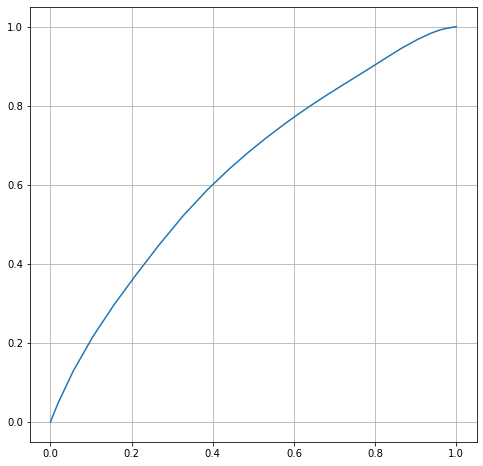

In [56]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
plt.plot( fr0, fr1)
plt.grid()
plt.show()

## Classifier (Django vs Rapgap) with adversarial NN that penalizes gen vs obs discrimination.

In [57]:
X_gen_and_obs = np.concatenate( [X_gen_r, X_gen_d, X_obs_r, X_obs_d] )
w_gen_and_obs = np.concatenate( [w_r, w_d, w_r, w_d])
Y_gen_and_obs = np.concatenate( [Y_r, Y_d, Y_r, Y_d])
Z_gen_and_obs = np.concatenate( [np.zeros(len(X_gen_r)), np.zeros(len(X_gen_d)), np.ones(len(X_obs_r)), np.ones(len(X_obs_d))])

In [58]:

scaler_file = "%s/input-scaler-gen-and-obs.pkl" % output_dir

if run_training :
    print("Creating new scalar.")
    scalerX_gen_and_obs = StandardScaler()
    scalerX_gen_and_obs.fit(X_gen_and_obs)
else :
    print("Reading scaler from file: %s" % scaler_file )
    scalerX_gen_and_obs = load( open(scaler_file, 'rb') )
    
Xs_gen_and_obs = scalerX_gen_and_obs.transform(X_gen_and_obs)

if run_training :
    print( "Saving scalar to %s" % scaler_file )
    dump( scalerX_gen_and_obs, open(scaler_file, 'wb'))
    

Creating new scalar.
Saving scalar to version5a-lambda1.00-no-weights-training-output/input-scaler-gen-and-obs.pkl


In [59]:
X_gen_and_obs_train, X_gen_and_obs_test, Y_gen_and_obs_train, Y_gen_and_obs_test, Z_gen_and_obs_train, Z_gen_and_obs_test, w_gen_and_obs_train, w_gen_and_obs_test = train_test_split( Xs_gen_and_obs, Y_gen_and_obs, Z_gen_and_obs, w_gen_and_obs, test_size=0.5 )

In [60]:
print("\n shapes:  X_gen_and_obs_train = %s " % str(np.shape(X_gen_and_obs_train)) )
print(" shapes:  Y_gen_and_obs_train = %s " % str(np.shape(Y_gen_and_obs_train)) )
print(" shapes:  Z_gen_and_obs_train = %s \n" % str(np.shape(Z_gen_and_obs_train)) )


 shapes:  X_gen_and_obs_train = (25531563, 9) 
 shapes:  Y_gen_and_obs_train = (25531563, 1) 
 shapes:  Z_gen_and_obs_train = (25531563,) 



In [61]:
@tf.custom_gradient
def grad_reverse(x, scale=10.):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy * scale
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super(GradReverse, self).__init__()

    def call(self, x):
        return grad_reverse(x)

In [62]:
n_hidden_inv = 2; n_hidden_inv_R = 5
n_nodes_inv = 50; n_nodes_inv_R = 50


inputs = Input(shape=(9,))
inputs_label = Input(shape=(1,))

Dx = Dense(n_nodes_inv, activation="relu")(inputs)
for i in range(n_hidden_inv -1):
    Dx = Dense(n_nodes_inv, activation='relu')(Dx)
Dx = Dense(1, activation="sigmoid", name="Clf")(Dx)
inv_model = Model(inputs=inputs, outputs=Dx)

GRx = GradReverse()(Dx)
GRx_con = tf.keras.layers.concatenate([GRx,inputs_label])
Rx = Dense(n_nodes_inv_R, activation="relu")(GRx_con)
for i in range(n_hidden_inv_R -1):
    Rx = Dense(n_nodes_inv_R, activation='relu')(Rx)

Rx = Dense(1, activation="sigmoid", name="Adv")(Rx)
GR = Model(inputs=[inputs,inputs_label], outputs=[Dx, Rx])

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )


if use_weights :
    
    print("\n\n Training with weights.\n\n")
        
    GR.compile(loss=["binary_crossentropy", "binary_crossentropy"], 
           loss_weights=[1,hp_lambda], optimizer=opt_adam,
           weighted_metrics=['accuracy']   ) 
else :
    GR.compile(loss=["binary_crossentropy", "binary_crossentropy"], 
           loss_weights=[1,hp_lambda], optimizer=opt_adam)     

In [63]:
%%time

if run_training :
    
    if use_weights :
        
        print("\n\n Training with weights.\n\n")

        GRhist = GR.fit(x=[X_gen_and_obs_train, Y_gen_and_obs_train], 
                y=[Y_gen_and_obs_train, Z_gen_and_obs_train], 
                sample_weight=[w_gen_and_obs_train, w_gen_and_obs_train],
                validation_data=([X_gen_and_obs_test, Y_gen_and_obs_test],[Y_gen_and_obs_test, Z_gen_and_obs_test], [w_gen_and_obs_test, w_gen_and_obs_test]) ,
                epochs=max_epochs, batch_size=batch_size_setval, verbose = 1, callbacks=[earlystopping] )

        
    else :
    
        GRhist = GR.fit(x=[X_gen_and_obs_train, Y_gen_and_obs_train], 
                y=[Y_gen_and_obs_train, Z_gen_and_obs_train], 
                validation_data=([X_gen_and_obs_test, Y_gen_and_obs_test],[Y_gen_and_obs_test, Z_gen_and_obs_test]),
                epochs=max_epochs, batch_size=batch_size_setval, verbose = 1, callbacks=[earlystopping] )
        
        

Epoch 1/5000
49867/49867 [==============================] - 283s 6ms/step - loss: 1.3698 - Clf_loss: 0.6767 - Adv_loss: 0.6931 - val_loss: 1.3688 - val_Clf_loss: 0.6756 - val_Adv_loss: 0.6932
Epoch 2/5000
49867/49867 [==============================] - 281s 6ms/step - loss: 1.3676 - Clf_loss: 0.6745 - Adv_loss: 0.6931 - val_loss: 1.3673 - val_Clf_loss: 0.6742 - val_Adv_loss: 0.6932
Epoch 3/5000
49867/49867 [==============================] - 285s 6ms/step - loss: 1.3669 - Clf_loss: 0.6738 - Adv_loss: 0.6931 - val_loss: 1.3668 - val_Clf_loss: 0.6737 - val_Adv_loss: 0.6932
Epoch 4/5000
49867/49867 [==============================] - 287s 6ms/step - loss: 1.3665 - Clf_loss: 0.6734 - Adv_loss: 0.6931 - val_loss: 1.3658 - val_Clf_loss: 0.6728 - val_Adv_loss: 0.6931
Epoch 5/5000
49867/49867 [==============================] - 285s 6ms/step - loss: 1.3662 - Clf_loss: 0.6731 - Adv_loss: 0.6931 - val_loss: 1.3661 - val_Clf_loss: 0.6730 - val_Adv_loss: 0.6931
Epoch 6/5000
49867/49867 [==============

49867/49867 [==============================] - 284s 6ms/step - loss: 1.3615 - Clf_loss: 0.6685 - Adv_loss: 0.6930 - val_loss: 1.3615 - val_Clf_loss: 0.6685 - val_Adv_loss: 0.6930
Epoch 44/5000
49867/49867 [==============================] - 284s 6ms/step - loss: 1.3614 - Clf_loss: 0.6684 - Adv_loss: 0.6930 - val_loss: 1.3616 - val_Clf_loss: 0.6686 - val_Adv_loss: 0.6930
Epoch 45/5000
49867/49867 [==============================] - 277s 6ms/step - loss: 1.3614 - Clf_loss: 0.6684 - Adv_loss: 0.6930 - val_loss: 1.3615 - val_Clf_loss: 0.6685 - val_Adv_loss: 0.6930
Epoch 46/5000
49867/49867 [==============================] - 284s 6ms/step - loss: 1.3614 - Clf_loss: 0.6684 - Adv_loss: 0.6930 - val_loss: 1.3606 - val_Clf_loss: 0.6677 - val_Adv_loss: 0.6929
Epoch 47/5000
49867/49867 [==============================] - 286s 6ms/step - loss: 1.3613 - Clf_loss: 0.6683 - Adv_loss: 0.6930 - val_loss: 1.3613 - val_Clf_loss: 0.6683 - val_Adv_loss: 0.6930
Epoch 48/5000
49867/49867 [======================

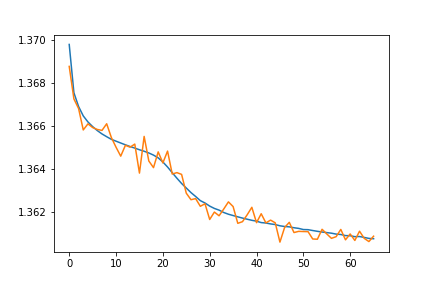

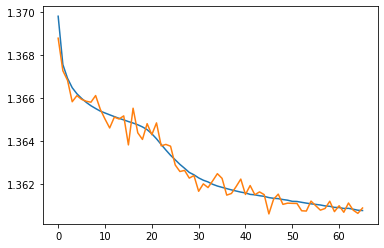

In [64]:
if run_training :
    plt.plot(GRhist.history['loss'])
    plt.plot(GRhist.history['val_loss'])
    plt.savefig('%s/loss-vs-epoch-adversarial-gen-and-obs-inputs.pdf' % output_dir )
    plt.savefig('%s/loss-vs-epoch-adversarial-gen-and-obs-inputs.png' % output_dir )

display.Image('%s/loss-vs-epoch-adversarial-gen-and-obs-inputs.png' % output_dir )

In [65]:
if run_training :
    tf.keras.models.save_model( GR, '%s/model-adversarial-gen-and-obs-inputs' % output_dir )
    tf.keras.models.save_model( inv_model, '%s/model-adversarial-gen-and-obs-inputs-classifier-only' % output_dir )
else :
    GR = tf.keras.models.load_model( '%s/model-adversarial-gen-and-obs-inputs' % output_dir )
    inv_model = tf.keras.models.load_model( '%s/model-adversarial-gen-and-obs-inputs-classifier-only' % output_dir )

INFO:tensorflow:Assets written to: version5a-lambda1.00-no-weights-training-output/model-adversarial-gen-and-obs-inputs/assets
INFO:tensorflow:Assets written to: version5a-lambda1.00-no-weights-training-output/model-adversarial-gen-and-obs-inputs-classifier-only/assets


In [66]:
GR.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 50)           500         ['input_1[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 50)           2550        ['dense_3[0][0]']                
                                                                                                  
 Clf (Dense)                    (None, 1)            51          ['dense_4[0][0]']                
                                                                                            

In [67]:
inv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_3 (Dense)             (None, 50)                500       
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 Clf (Dense)                 (None, 1)                 51        
                                                                 
Total params: 3,101
Trainable params: 3,101
Non-trainable params: 0
_________________________________________________________________


In [68]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 9), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [69]:
print(inputs_label)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [70]:
print(inv_model)

In [71]:
print(Dx)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='Clf/Sigmoid:0', description="created by layer 'Clf'")


In [72]:
print(GRx)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='grad_reverse/IdentityN:0', description="created by layer 'grad_reverse'")


In [73]:
print(GRx_con)

KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [74]:
print(Rx)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='Adv/Sigmoid:0', description="created by layer 'Adv'")


In [75]:
print(GR)

In [76]:
classifier_output_adv = inv_model.predict( X_gen_and_obs_test, batch_size=2048 )

12467/12467 [==============================] - 7s 561us/step


In [77]:
Xs_gen_d = scalerX_gen_and_obs.transform( X_gen_d )
Xs_obs_d = scalerX_gen_and_obs.transform( X_obs_d )
Xs_gen_r = scalerX_gen_and_obs.transform( X_gen_r )
Xs_obs_r = scalerX_gen_and_obs.transform( X_obs_r )




classifier_output_django_gen = inv_model.predict( Xs_gen_d, batch_size=2048 )
classifier_output_django_obs = inv_model.predict( Xs_obs_d, batch_size=2048 )
classifier_output_rapgap_gen = inv_model.predict( Xs_gen_r, batch_size=2048 )
classifier_output_rapgap_obs = inv_model.predict( Xs_obs_r, batch_size=2048 )

6068/6068 [==============================] - 3s 529us/step


Turning off weights.


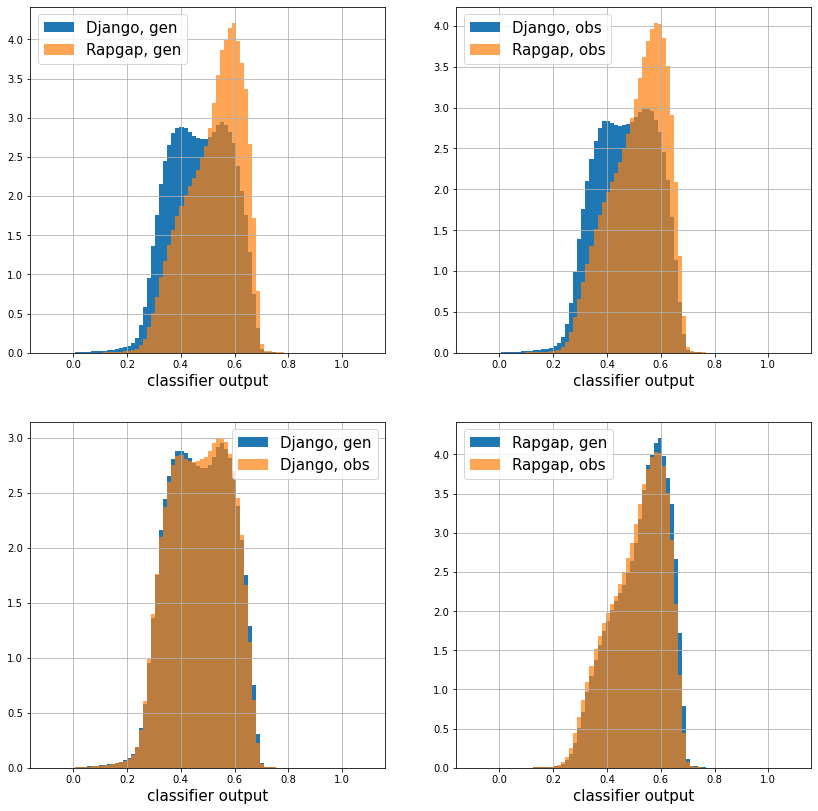

In [78]:
fig,ax = plt.subplots(2,2,figsize=(14,14))

hweights_r = w_r
hweights_d = w_d

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights_r.fill(1)
    hweights_d.fill(1)


ax[0][0].hist( classifier_output_django_gen, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[0][0].hist( classifier_output_rapgap_gen, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen', alpha=0.7)
      
ax[0][1].hist( classifier_output_django_obs, weights=hweights_d, 
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs' )
ax[0][1].hist( classifier_output_rapgap_obs, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7)

ax[1][0].hist( classifier_output_django_gen, weights=hweights_d, 
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[1][0].hist( classifier_output_django_obs, weights=hweights_d, 
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs', alpha=0.7 )


ax[1][1].hist( classifier_output_rapgap_gen, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen' )
ax[1][1].hist( classifier_output_rapgap_obs, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7 )




ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()



hfontsize=15

ax[0][0].set_xlabel('classifier output', fontsize=hfontsize)
ax[1][0].set_xlabel('classifier output', fontsize=hfontsize)
ax[0][1].set_xlabel('classifier output', fontsize=hfontsize)
ax[1][1].set_xlabel('classifier output', fontsize=hfontsize)



ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)


plt.show()

In [79]:
if use_weights :
    full_model_fpr, full_model_tpr, _ = roc_curve( Y_gen_and_obs_test, classifier_output_adv, sample_weight=w_gen_and_obs_test)
else :
    full_model_fpr, full_model_tpr, _ = roc_curve( Y_gen_and_obs_test, classifier_output_adv)

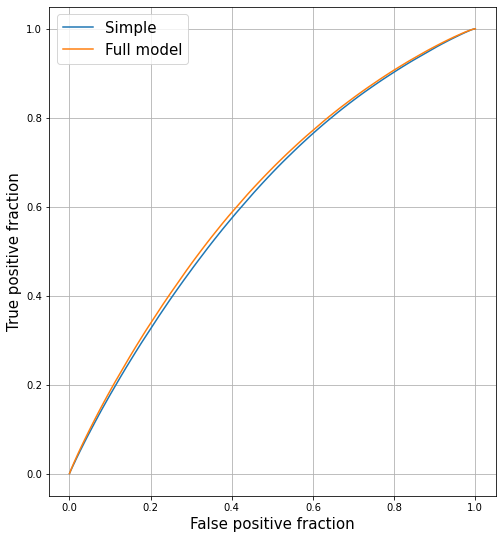

In [80]:
fig,ax = plt.subplots(1,1,figsize=(8,9))
plt.plot( simple_fpr, simple_tpr, label='Simple')
plt.plot( full_model_fpr, full_model_tpr, label='Full model')
plt.grid()
ax.set_xlabel('False positive fraction', fontsize=15)
ax.set_ylabel('True positive fraction', fontsize=15)
ax.legend( loc='best', fontsize=15)
plt.show()

In [81]:
overall_preds = GR.predict( [X_gen_and_obs_test, Y_gen_and_obs_test], batch_size=2048 )

12467/12467 [==============================] - 13s 989us/step


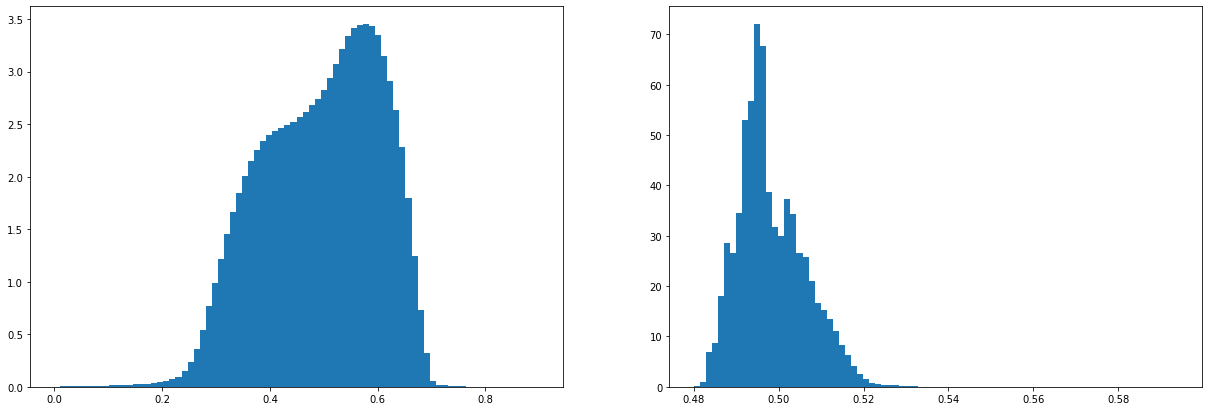

In [82]:
fig,ax = plt.subplots(1,2,figsize=(21,7))

ax[0].hist( overall_preds[0], bins=80, density=True )

ax[1].hist( overall_preds[1], bins=80, density=True )

plt.show()

## Inspect the adversary NN function and compare to what is expected, derived from histograms

In [83]:
%%time

#-- arrgh.  Can't figure out how to do this in the numpy way that doesn't take a ton of memory...  
#   Do it the slow way.

preds_clf_r_gen = np.zeros(len(Y_gen_and_obs_test))
preds_clf_r_obs = np.zeros(len(Y_gen_and_obs_test))
preds_clf_d_gen = np.zeros(len(Y_gen_and_obs_test))
preds_clf_d_obs = np.zeros(len(Y_gen_and_obs_test))

w_r_gen = np.zeros(len(Y_gen_and_obs_test))
w_r_obs = np.zeros(len(Y_gen_and_obs_test))
w_d_gen = np.zeros(len(Y_gen_and_obs_test))
w_d_obs = np.zeros(len(Y_gen_and_obs_test))

count_r_gen = 0
count_r_obs = 0
count_d_gen = 0
count_d_obs = 0

for i in range(len(overall_preds[0])):
    
    if i%100000 == 0 :
        print(i)
        
    if Y_gen_and_obs_test[i] == 1 and Z_gen_and_obs_test[i] == 0 :
        preds_clf_r_gen[count_r_gen] =  overall_preds[0][i]
        w_r_gen[count_r_gen] =  w_gen_and_obs_test[i] 
        count_r_gen = count_r_gen + 1
        
    if Y_gen_and_obs_test[i] == 1 and Z_gen_and_obs_test[i] == 1 :
        preds_clf_r_obs[count_r_obs] =  overall_preds[0][i] 
        w_r_obs[count_r_obs] =  w_gen_and_obs_test[i] 
        count_r_obs = count_r_obs + 1
        
    if Y_gen_and_obs_test[i] == 0 and Z_gen_and_obs_test[i] == 0 :
        preds_clf_d_gen[count_d_gen] = overall_preds[0][i] 
        w_d_gen[count_d_gen] = w_gen_and_obs_test[i] 
        count_d_gen = count_d_gen + 1
        
    if Y_gen_and_obs_test[i] == 0 and Z_gen_and_obs_test[i] == 1 :
        preds_clf_d_obs[count_d_obs] = overall_preds[0][i] 
        w_d_obs[count_d_obs] = w_gen_and_obs_test[i] 
        count_d_obs = count_d_obs + 1
        

        
preds_clf_r_gen = np.resize(preds_clf_r_gen,[count_r_gen])
w_r_gen = np.resize(w_r_gen,[count_r_gen])

preds_clf_r_obs = np.resize(preds_clf_r_obs,[count_r_obs])
w_r_obs = np.resize(w_r_obs,[count_r_obs])

preds_clf_d_gen = np.resize(preds_clf_d_gen,[count_d_gen])
w_d_gen = np.resize(w_d_gen,[count_d_gen])

preds_clf_d_obs = np.resize(preds_clf_d_obs,[count_d_obs])
w_d_obs = np.resize(w_d_obs,[count_d_obs])




0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000

Turning off weights.


/tmp/ipykernel_338418/2370017081.py:64: RuntimeWarning: invalid value encountered in double_scalars
  herr_d[i] = np.sqrt( hprobd[i]*(1-hprobd[i])/(o+g) )  #-- incorrect when using weights.
/tmp/ipykernel_338418/2370017081.py:60: RuntimeWarning: invalid value encountered in double_scalars
  herr_r[i] = np.sqrt( hprobr[i]*(1-hprobr[i])/(o+g) )  #-- incorrect when using weights.


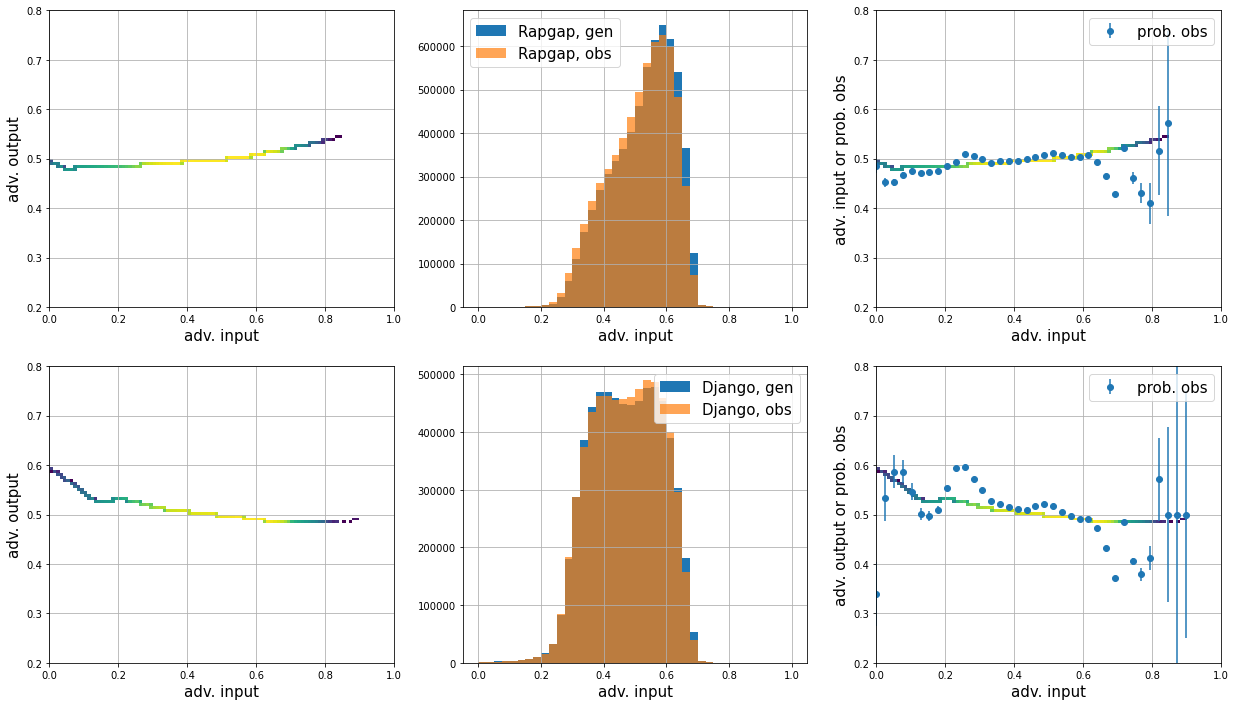

In [84]:
fig,ax = plt.subplots(2,3,figsize=(21,12))

hbins=40

hymin=0.20
hymax=0.80


hweights = w_gen_and_obs_test


if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights.fill(1)
    w_r_gen.fill(1)
    w_r_obs.fill(1)
    w_d_gen.fill(1)
    w_d_obs.fill(1)



ax[0][0].hist2d( overall_preds[0][Y_gen_and_obs_test==0], 
                overall_preds[1][Y_gen_and_obs_test==0], 
                weights=hweights[Y_gen_and_obs_test==0],
                bins=100, norm=mpl.colors.LogNorm(), range=([0,1],[hymin,hymax]) )

ax[1][0].hist2d( overall_preds[0][Y_gen_and_obs_test==1], 
                overall_preds[1][Y_gen_and_obs_test==1], 
                weights=hweights[Y_gen_and_obs_test==1],
                bins=100, norm=mpl.colors.LogNorm(), range=([0,1],[hymin,hymax]) )



hrg = ax[0][1].hist( preds_clf_r_gen, weights=w_r_gen,
                    bins=hbins, range=[0,1], label='Rapgap, gen' )
hro = ax[0][1].hist( preds_clf_r_obs, weights=w_r_obs,
                    bins=hbins, range=[0,1], label='Rapgap, obs', alpha=0.7 )

hdg = ax[1][1].hist( preds_clf_d_gen, weights=w_d_gen,
                    bins=hbins, range=[0,1], label='Django, gen'  )
hdo = ax[1][1].hist( preds_clf_d_obs, weights=w_d_obs,
                    bins=hbins, range=[0,1], label='Django, obs', alpha=0.7 )





hprobr = np.zeros(len(hro[0]) )
hprobd = np.zeros(len(hdo[0]) )
herr_r = np.zeros(len(hro[0]) )
herr_d = np.zeros(len(hdo[0]) )

paxis = np.linspace( 0, 1, len(hro[0]) )
for i in range(len(hro[0])):
    o = hro[0][i]
    g = hrg[0][i]
    if o != 0 and g != 0 : hprobr[i] = o / (o+g)
    herr_r[i] = np.sqrt( hprobr[i]*(1-hprobr[i])/(o+g) )  #-- incorrect when using weights.
    o = hdo[0][i]
    g = hdg[0][i]
    if o != 0 and g != 0 : hprobd[i] = o / (o+g)
    herr_d[i] = np.sqrt( hprobd[i]*(1-hprobd[i])/(o+g) )  #-- incorrect when using weights.

 



ax[0][2].hist2d( overall_preds[0][Y_gen_and_obs_test==0], 
                overall_preds[1][Y_gen_and_obs_test==0], 
                bins=100, norm=mpl.colors.LogNorm(), range=([0,1],[hymin,hymax]),
               label='adv. output')

ax[0][2].errorbar( paxis, hprobd, yerr=herr_d, fmt='o', label='prob. obs' ) 




ax[1][2].hist2d( overall_preds[0][Y_gen_and_obs_test==1], 
                overall_preds[1][Y_gen_and_obs_test==1], 
                bins=100, norm=mpl.colors.LogNorm(), range=([0,1],[hymin,hymax]) )

ax[1][2].errorbar( paxis, hprobr, yerr=herr_r, fmt='o', label='prob. obs' ) 



ax[0][0].grid()
ax[0][1].grid()
ax[0][2].grid()


ax[1][0].grid()
ax[1][1].grid()
ax[1][2].grid()




fontsize=15

ax[0][0].set_xlabel('adv. input', fontsize=hfontsize)
ax[0][0].set_ylabel('adv. output', fontsize=hfontsize)

ax[1][0].set_xlabel('adv. input', fontsize=hfontsize)
ax[1][0].set_ylabel('adv. output', fontsize=hfontsize)

ax[0][1].set_xlabel('adv. input', fontsize=hfontsize)
ax[0][2].set_xlabel('adv. input', fontsize=hfontsize)
ax[1][1].set_xlabel('adv. input', fontsize=hfontsize)
ax[1][2].set_xlabel('adv. input', fontsize=hfontsize)

ax[0][2].set_ylabel('adv. input or prob. obs', fontsize=hfontsize)
ax[1][2].set_ylabel('adv. output or prob. obs', fontsize=hfontsize)



ax[0][1].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)

ax[0][2].legend( loc='best', fontsize=hfontsize)
ax[1][2].legend( loc='best', fontsize=hfontsize)

    
plt.show()

## Test with Lambda = 0 to turn off adversary

In [85]:
n_hidden_inv = 2; n_hidden_inv_R = 5
n_nodes_inv = 50; n_nodes_inv_R = 50
hp_lambda0 = 0.

inputs = Input(shape=(9,))
inputs_label = Input(shape=(1,))

Dx_lam0 = Dense(n_nodes_inv, activation="relu")(inputs)
for i in range(n_hidden_inv -1):
    Dx_lam0 = Dense(n_nodes_inv, activation='relu')(Dx_lam0)
Dx_lam0 = Dense(1, activation="sigmoid", name="Clf")(Dx_lam0)
inv_model_lam0 = Model(inputs=inputs, outputs=Dx_lam0)

GRx_lam0 = GradReverse()(Dx_lam0)
GRx_con_lam0 = tf.keras.layers.concatenate([GRx_lam0,inputs_label])
Rx_lam0 = Dense(n_nodes_inv_R, activation="relu")(GRx_con_lam0)
for i in range(n_hidden_inv_R -1):
    Rx_lam0 = Dense(n_nodes_inv_R, activation='relu')(Rx_lam0)

Rx_lam0 = Dense(1, activation="sigmoid", name="Adv")(Rx_lam0)
GR_lam0 = Model(inputs=[inputs,inputs_label], outputs=[Dx_lam0, Rx_lam0])

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )


if use_weights :
    
    print("\n\n Training with weights\n\n")    

    GR_lam0.compile(loss=["binary_crossentropy", "binary_crossentropy"], 
                loss_weights=[1,hp_lambda0], optimizer=opt_adam,
                       weighted_metrics=['accuracy'])
else :

    GR_lam0.compile(loss=["binary_crossentropy", "binary_crossentropy"], 
                loss_weights=[1,hp_lambda0], optimizer=opt_adam)

In [86]:
%%time

if run_training :
    
    if use_weights :
        
        print("\n\n Training with weights\n\n")    
        
        GRhist_lam0 = GR_lam0.fit(x=[X_gen_and_obs_train, Y_gen_and_obs_train], 
                y=[Y_gen_and_obs_train, Z_gen_and_obs_train],
                sample_weight=[w_gen_and_obs_train, w_gen_and_obs_train],
                validation_data=([X_gen_and_obs_test, Y_gen_and_obs_test],[Y_gen_and_obs_test, Z_gen_and_obs_test], [w_gen_and_obs_test, w_gen_and_obs_test]),
                epochs=max_epochs, batch_size=batch_size_setval, verbose = 1, callbacks=[earlystopping] )
        
    else :
    
        GRhist_lam0 = GR_lam0.fit(x=[X_gen_and_obs_train, Y_gen_and_obs_train], 
                y=[Y_gen_and_obs_train, Z_gen_and_obs_train], 
                validation_data=([X_gen_and_obs_test, Y_gen_and_obs_test],[Y_gen_and_obs_test, Z_gen_and_obs_test]),
                epochs=max_epochs, batch_size=batch_size_setval, verbose = 1, callbacks=[earlystopping] )

Epoch 1/5000
49867/49867 [==============================] - 289s 6ms/step - loss: 0.6689 - Clf_loss: 0.6689 - Adv_loss: 0.6933 - val_loss: 0.6659 - val_Clf_loss: 0.6659 - val_Adv_loss: 0.6933
Epoch 2/5000
49867/49867 [==============================] - 284s 6ms/step - loss: 0.6649 - Clf_loss: 0.6649 - Adv_loss: 0.6933 - val_loss: 0.6638 - val_Clf_loss: 0.6638 - val_Adv_loss: 0.6933
Epoch 3/5000
49867/49867 [==============================] - 287s 6ms/step - loss: 0.6628 - Clf_loss: 0.6628 - Adv_loss: 0.6933 - val_loss: 0.6620 - val_Clf_loss: 0.6620 - val_Adv_loss: 0.6933
Epoch 4/5000
49867/49867 [==============================] - 287s 6ms/step - loss: 0.6613 - Clf_loss: 0.6613 - Adv_loss: 0.6933 - val_loss: 0.6608 - val_Clf_loss: 0.6608 - val_Adv_loss: 0.6932
Epoch 5/5000
49867/49867 [==============================] - 280s 6ms/step - loss: 0.6604 - Clf_loss: 0.6604 - Adv_loss: 0.6933 - val_loss: 0.6601 - val_Clf_loss: 0.6601 - val_Adv_loss: 0.6932
Epoch 6/5000
49867/49867 [==============

49867/49867 [==============================] - 287s 6ms/step - loss: 0.6562 - Clf_loss: 0.6562 - Adv_loss: 0.6933 - val_loss: 0.6561 - val_Clf_loss: 0.6561 - val_Adv_loss: 0.6933
Epoch 44/5000
49867/49867 [==============================] - 287s 6ms/step - loss: 0.6561 - Clf_loss: 0.6561 - Adv_loss: 0.6933 - val_loss: 0.6560 - val_Clf_loss: 0.6560 - val_Adv_loss: 0.6933
Epoch 45/5000
49867/49867 [==============================] - 286s 6ms/step - loss: 0.6560 - Clf_loss: 0.6560 - Adv_loss: 0.6933 - val_loss: 0.6560 - val_Clf_loss: 0.6560 - val_Adv_loss: 0.6933
Epoch 46/5000
49867/49867 [==============================] - 287s 6ms/step - loss: 0.6558 - Clf_loss: 0.6558 - Adv_loss: 0.6933 - val_loss: 0.6558 - val_Clf_loss: 0.6558 - val_Adv_loss: 0.6933
Epoch 47/5000
49867/49867 [==============================] - 287s 6ms/step - loss: 0.6557 - Clf_loss: 0.6557 - Adv_loss: 0.6933 - val_loss: 0.6558 - val_Clf_loss: 0.6558 - val_Adv_loss: 0.6933
Epoch 48/5000
49867/49867 [======================

49867/49867 [==============================] - 291s 6ms/step - loss: 0.6494 - Clf_loss: 0.6494 - Adv_loss: 0.6935 - val_loss: 0.6495 - val_Clf_loss: 0.6495 - val_Adv_loss: 0.6934
Epoch 86/5000
49867/49867 [==============================] - 290s 6ms/step - loss: 0.6493 - Clf_loss: 0.6493 - Adv_loss: 0.6935 - val_loss: 0.6496 - val_Clf_loss: 0.6496 - val_Adv_loss: 0.6935
Epoch 87/5000
49867/49867 [==============================] - 289s 6ms/step - loss: 0.6492 - Clf_loss: 0.6492 - Adv_loss: 0.6935 - val_loss: 0.6493 - val_Clf_loss: 0.6493 - val_Adv_loss: 0.6935
Epoch 88/5000
49867/49867 [==============================] - 289s 6ms/step - loss: 0.6492 - Clf_loss: 0.6492 - Adv_loss: 0.6935 - val_loss: 0.6494 - val_Clf_loss: 0.6494 - val_Adv_loss: 0.6935
Epoch 89/5000
49867/49867 [==============================] - 288s 6ms/step - loss: 0.6491 - Clf_loss: 0.6491 - Adv_loss: 0.6935 - val_loss: 0.6491 - val_Clf_loss: 0.6491 - val_Adv_loss: 0.6935
Epoch 90/5000
49867/49867 [======================

49867/49867 [==============================] - 289s 6ms/step - loss: 0.6477 - Clf_loss: 0.6477 - Adv_loss: 0.6935 - val_loss: 0.6479 - val_Clf_loss: 0.6479 - val_Adv_loss: 0.6935
Epoch 128/5000
49867/49867 [==============================] - 289s 6ms/step - loss: 0.6476 - Clf_loss: 0.6476 - Adv_loss: 0.6935 - val_loss: 0.6478 - val_Clf_loss: 0.6478 - val_Adv_loss: 0.6935
Epoch 129/5000
49867/49867 [==============================] - 287s 6ms/step - loss: 0.6476 - Clf_loss: 0.6476 - Adv_loss: 0.6935 - val_loss: 0.6479 - val_Clf_loss: 0.6479 - val_Adv_loss: 0.6935
Epoch 130/5000
49867/49867 [==============================] - 293s 6ms/step - loss: 0.6476 - Clf_loss: 0.6476 - Adv_loss: 0.6935 - val_loss: 0.6477 - val_Clf_loss: 0.6477 - val_Adv_loss: 0.6935
Epoch 131/5000
49867/49867 [==============================] - 291s 6ms/step - loss: 0.6475 - Clf_loss: 0.6475 - Adv_loss: 0.6935 - val_loss: 0.6477 - val_Clf_loss: 0.6477 - val_Adv_loss: 0.6935
Epoch 132/5000
49867/49867 [=================

49867/49867 [==============================] - 289s 6ms/step - loss: 0.6468 - Clf_loss: 0.6468 - Adv_loss: 0.6935 - val_loss: 0.6474 - val_Clf_loss: 0.6474 - val_Adv_loss: 0.6935
Epoch 170/5000
49867/49867 [==============================] - 289s 6ms/step - loss: 0.6468 - Clf_loss: 0.6468 - Adv_loss: 0.6936 - val_loss: 0.6465 - val_Clf_loss: 0.6465 - val_Adv_loss: 0.6936
Epoch 171/5000
49867/49867 [==============================] - 291s 6ms/step - loss: 0.6468 - Clf_loss: 0.6468 - Adv_loss: 0.6936 - val_loss: 0.6468 - val_Clf_loss: 0.6468 - val_Adv_loss: 0.6936
Epoch 172/5000
49867/49867 [==============================] - 290s 6ms/step - loss: 0.6467 - Clf_loss: 0.6467 - Adv_loss: 0.6936 - val_loss: 0.6466 - val_Clf_loss: 0.6466 - val_Adv_loss: 0.6935
Epoch 173/5000
49867/49867 [==============================] - 290s 6ms/step - loss: 0.6467 - Clf_loss: 0.6467 - Adv_loss: 0.6936 - val_loss: 0.6468 - val_Clf_loss: 0.6468 - val_Adv_loss: 0.6935
Epoch 174/5000
49867/49867 [=================

49867/49867 [==============================] - 289s 6ms/step - loss: 0.6463 - Clf_loss: 0.6463 - Adv_loss: 0.6936 - val_loss: 0.6463 - val_Clf_loss: 0.6463 - val_Adv_loss: 0.6935
Epoch 212/5000
49867/49867 [==============================] - 293s 6ms/step - loss: 0.6462 - Clf_loss: 0.6462 - Adv_loss: 0.6936 - val_loss: 0.6465 - val_Clf_loss: 0.6465 - val_Adv_loss: 0.6936
Epoch 213/5000
49867/49867 [==============================] - 288s 6ms/step - loss: 0.6462 - Clf_loss: 0.6462 - Adv_loss: 0.6936 - val_loss: 0.6464 - val_Clf_loss: 0.6464 - val_Adv_loss: 0.6936
Epoch 214/5000
49867/49867 [==============================] - 288s 6ms/step - loss: 0.6462 - Clf_loss: 0.6462 - Adv_loss: 0.6936 - val_loss: 0.6460 - val_Clf_loss: 0.6460 - val_Adv_loss: 0.6935
Epoch 215/5000
49867/49867 [==============================] - 290s 6ms/step - loss: 0.6462 - Clf_loss: 0.6462 - Adv_loss: 0.6936 - val_loss: 0.6460 - val_Clf_loss: 0.6460 - val_Adv_loss: 0.6936
Epoch 216/5000
49867/49867 [=================

49867/49867 [==============================] - 289s 6ms/step - loss: 0.6459 - Clf_loss: 0.6459 - Adv_loss: 0.6936 - val_loss: 0.6462 - val_Clf_loss: 0.6462 - val_Adv_loss: 0.6936
Epoch 254/5000
49867/49867 [==============================] - 290s 6ms/step - loss: 0.6459 - Clf_loss: 0.6459 - Adv_loss: 0.6936 - val_loss: 0.6457 - val_Clf_loss: 0.6457 - val_Adv_loss: 0.6936
Epoch 255/5000
49867/49867 [==============================] - 281s 6ms/step - loss: 0.6459 - Clf_loss: 0.6459 - Adv_loss: 0.6936 - val_loss: 0.6459 - val_Clf_loss: 0.6459 - val_Adv_loss: 0.6935
Epoch 256/5000
49867/49867 [==============================] - 288s 6ms/step - loss: 0.6459 - Clf_loss: 0.6459 - Adv_loss: 0.6936 - val_loss: 0.6458 - val_Clf_loss: 0.6458 - val_Adv_loss: 0.6936
Epoch 257/5000
49867/49867 [==============================] - 291s 6ms/step - loss: 0.6459 - Clf_loss: 0.6459 - Adv_loss: 0.6936 - val_loss: 0.6461 - val_Clf_loss: 0.6461 - val_Adv_loss: 0.6935
Epoch 258/5000
49867/49867 [=================

49867/49867 [==============================] - 287s 6ms/step - loss: 0.6457 - Clf_loss: 0.6457 - Adv_loss: 0.6936 - val_loss: 0.6456 - val_Clf_loss: 0.6456 - val_Adv_loss: 0.6936
Epoch 296/5000
49867/49867 [==============================] - 290s 6ms/step - loss: 0.6457 - Clf_loss: 0.6457 - Adv_loss: 0.6936 - val_loss: 0.6457 - val_Clf_loss: 0.6457 - val_Adv_loss: 0.6936
Epoch 297/5000
49867/49867 [==============================] - 290s 6ms/step - loss: 0.6457 - Clf_loss: 0.6457 - Adv_loss: 0.6936 - val_loss: 0.6454 - val_Clf_loss: 0.6454 - val_Adv_loss: 0.6936
Epoch 298/5000
49867/49867 [==============================] - 289s 6ms/step - loss: 0.6457 - Clf_loss: 0.6457 - Adv_loss: 0.6936 - val_loss: 0.6458 - val_Clf_loss: 0.6458 - val_Adv_loss: 0.6936
Epoch 299/5000
49867/49867 [==============================] - 288s 6ms/step - loss: 0.6457 - Clf_loss: 0.6457 - Adv_loss: 0.6936 - val_loss: 0.6455 - val_Clf_loss: 0.6455 - val_Adv_loss: 0.6936
Epoch 300/5000
49867/49867 [=================

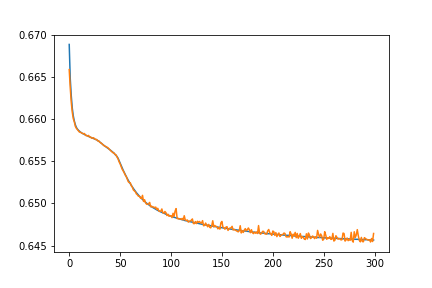

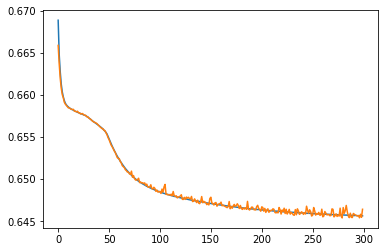

In [87]:
if run_training :
    plt.plot(GRhist_lam0.history['loss'])
    plt.plot(GRhist_lam0.history['val_loss'])
    plt.savefig('%s/loss-vs-epoch-adversarial-gen-and-obs-inputs-lambda0.pdf' % output_dir )
    plt.savefig('%s/loss-vs-epoch-adversarial-gen-and-obs-inputs-lambda0.png' % output_dir )

display.Image('%s/loss-vs-epoch-adversarial-gen-and-obs-inputs-lambda0.png' % output_dir )

In [88]:
if run_training :
    tf.keras.models.save_model( GR_lam0, '%s/model-adversarial-gen-and-obs-inputs-lambda0' % output_dir )
    tf.keras.models.save_model( inv_model_lam0, '%s/model-adversarial-gen-and-obs-inputs-lambda0-classifier-only' % output_dir )
else :
    GR_lam0 = tf.keras.models.load_model( '%s/model-adversarial-gen-and-obs-inputs-lambda0' % output_dir )
    inv_model_lam0 = tf.keras.models.load_model( '%s/model-adversarial-gen-and-obs-inputs-lambda0-classifier-only' % output_dir )

INFO:tensorflow:Assets written to: version5a-lambda1.00-no-weights-training-output/model-adversarial-gen-and-obs-inputs-lambda0/assets
INFO:tensorflow:Assets written to: version5a-lambda1.00-no-weights-training-output/model-adversarial-gen-and-obs-inputs-lambda0-classifier-only/assets


In [89]:
GR_lam0.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 50)           500         ['input_3[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 50)           2550        ['dense_10[0][0]']               
                                                                                                  
 Clf (Dense)                    (None, 1)            51          ['dense_11[0][0]']               
                                                                                            

In [90]:
inv_model_lam0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_10 (Dense)            (None, 50)                500       
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 Clf (Dense)                 (None, 1)                 51        
                                                                 
Total params: 3,101
Trainable params: 3,101
Non-trainable params: 0
_________________________________________________________________


In [91]:

classifier_output_django_gen_lam0 = inv_model_lam0.predict( Xs_gen_d, batch_size=2048 )
classifier_output_django_obs_lam0 = inv_model_lam0.predict( Xs_obs_d, batch_size=2048 )
classifier_output_rapgap_gen_lam0 = inv_model_lam0.predict( Xs_gen_r, batch_size=2048 )
classifier_output_rapgap_obs_lam0 = inv_model_lam0.predict( Xs_obs_r, batch_size=2048 )

6068/6068 [==============================] - 3s 529us/step


Turning off weights.


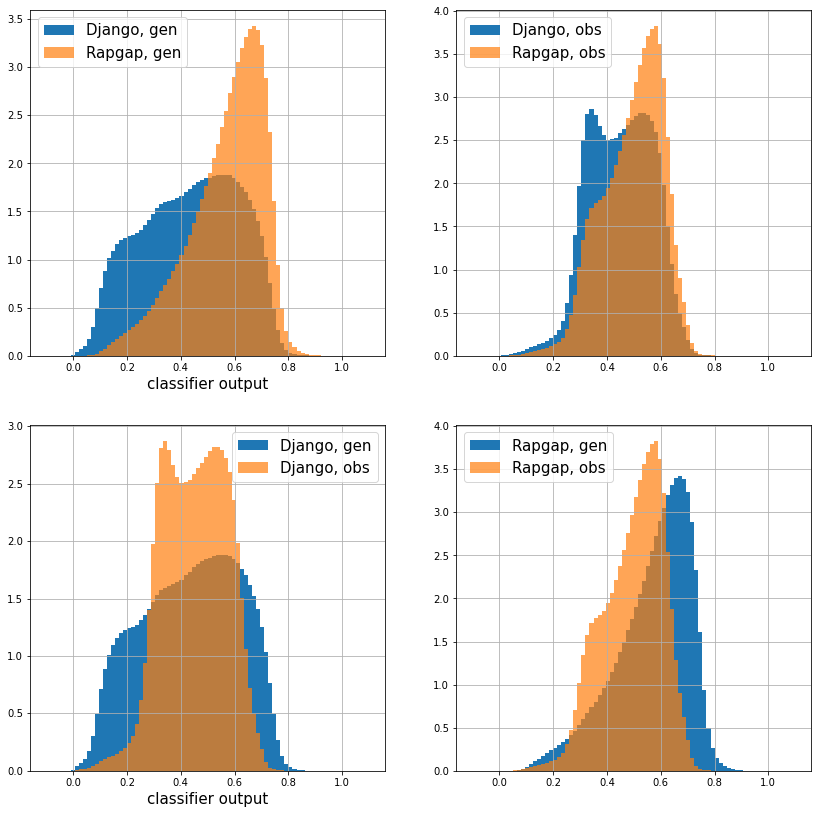

In [92]:
fig,ax = plt.subplots(2,2,figsize=(14,14))

hweights_r = w_r
hweights_d = w_d

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights_r.fill(1)
    hweights_d.fill(1)


ax[0][0].hist( classifier_output_django_gen_lam0, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[0][0].hist( classifier_output_rapgap_gen_lam0, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen', alpha=0.7)
      
ax[0][1].hist( classifier_output_django_obs_lam0, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs' )
ax[0][1].hist( classifier_output_rapgap_obs_lam0, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7)

ax[1][0].hist( classifier_output_django_gen_lam0, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[1][0].hist( classifier_output_django_obs_lam0, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs', alpha=0.7 )


ax[1][1].hist( classifier_output_rapgap_gen_lam0, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen' )
ax[1][1].hist( classifier_output_rapgap_obs_lam0, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7 )




ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()



hfontsize=15

ax[0][0].set_xlabel('classifier output', fontsize=hfontsize)
ax[1][0].set_xlabel('classifier output', fontsize=hfontsize)




ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)


plt.show()

In [93]:
classifier_output_adv_lam0 = inv_model_lam0.predict( X_gen_and_obs_test, batch_size=2048 )

12467/12467 [==============================] - 7s 551us/step


In [94]:
if use_weights :
    full_model_lam0_fpr, full_model_lam0_tpr, _ = roc_curve( Y_gen_and_obs_test, classifier_output_adv_lam0, sample_weight=w_gen_and_obs_test)
else :
    full_model_lam0_fpr, full_model_lam0_tpr, _ = roc_curve( Y_gen_and_obs_test, classifier_output_adv_lam0)

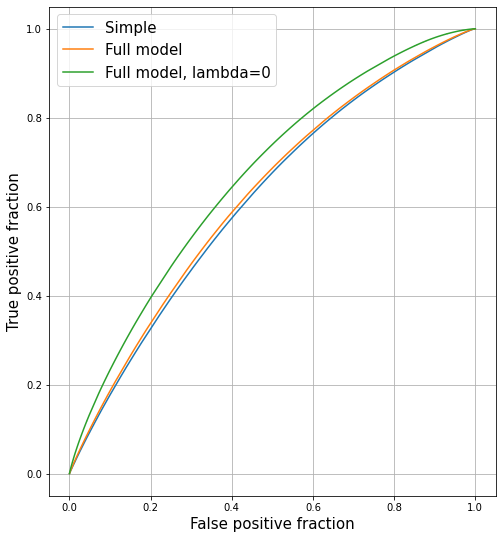

In [95]:
fig,ax = plt.subplots(1,1,figsize=(8,9))
plt.plot( simple_fpr, simple_tpr, label='Simple')
plt.plot( full_model_fpr, full_model_tpr, label='Full model')
plt.plot( full_model_lam0_fpr, full_model_lam0_tpr, label='Full model, lambda=0')
plt.grid()
ax.set_xlabel('False positive fraction', fontsize=15)
ax.set_ylabel('True positive fraction', fontsize=15)
ax.legend( loc='best', fontsize=15)
plt.show()

## Compare the response matrix for the  Simple classifier with the Full model
Here, the distribution is of the classifier output and we look at unfolding the distribution from detector-level inputs to the "true" distribution from particle-level inputs.

In [96]:
full_classifier_output_gen = inv_model.predict( Xs_gen, batch_size=2048 )
full_classifier_output_obs = inv_model.predict( Xs_obs, batch_size=2048 )

12467/12467 [==============================] - 7s 536us/step


In [97]:
full_classifier_lam0_output_gen = inv_model_lam0.predict( Xs_gen, batch_size=2048 )
full_classifier_lam0_output_obs = inv_model_lam0.predict( Xs_obs, batch_size=2048 )

12467/12467 [==============================] - 7s 537us/step


Turning off weights.


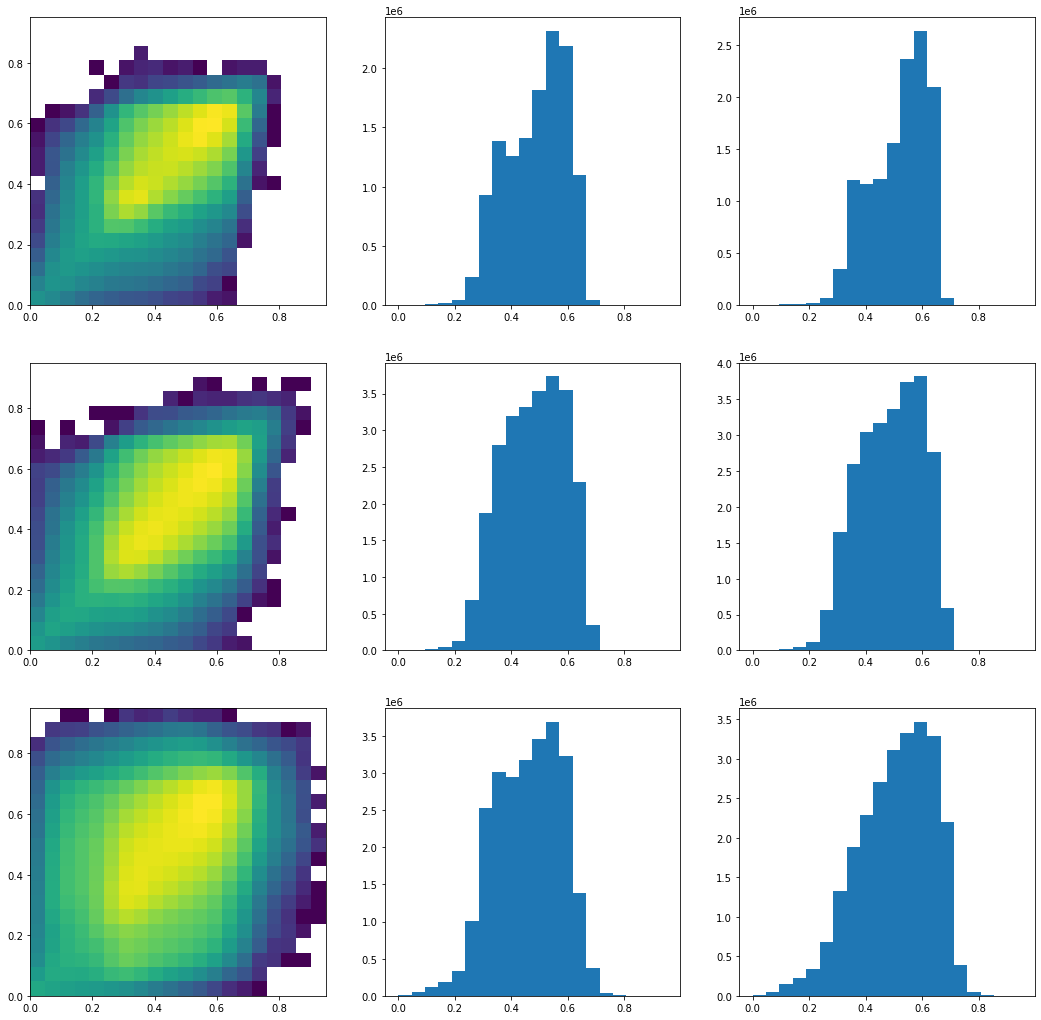

In [98]:
fig,ax = plt.subplots(3,3,figsize=(18,18))

response_min = 0.0
response_max = 0.95
response_bins = 20

hweights = w_test

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights.fill(1)




hist_simple = ax[0][0].hist2d( simple_classifier_output_obs[:,0], 
                simple_classifier_output_gen[:,0], 
                weights=hweights[:,0], 
                range=([response_min,response_max],[response_min,response_max]),
                bins=response_bins, 
                              norm=mpl.colors.LogNorm()
                             )

hist_simple_obs = ax[0][1].hist( 
                simple_classifier_output_obs[:,0], 
                range=[response_min,response_max],
                weights=hweights[:,0], 
                bins=response_bins)

hist_simple_gen = ax[0][2].hist( 
                simple_classifier_output_gen[:,0], 
                range=[response_min,response_max],
                weights=hweights[:,0], 
                bins=response_bins)


#-- Need to have obs/gen pairs for full model!
hist_full = ax[1][0].hist2d( full_classifier_output_obs[:,0], 
                full_classifier_output_gen[:,0],  
                range=([response_min,response_max],[response_min,response_max]),
                bins=response_bins, norm=mpl.colors.LogNorm())

hist_full_obs = ax[1][1].hist( 
                full_classifier_output_obs[:,0], 
                range=[response_min,response_max],
                bins=response_bins)

hist_full_gen = ax[1][2].hist( 
                full_classifier_output_gen[:,0], 
                range=[response_min,response_max],
                bins=response_bins)





hist_full_lam0 = ax[2][0].hist2d( full_classifier_lam0_output_obs[:,0], 
                full_classifier_lam0_output_gen[:,0],  
                range=([response_min,response_max],[response_min,response_max]),
                bins=response_bins, norm=mpl.colors.LogNorm())

hist_full_lam0_obs = ax[2][1].hist( 
                full_classifier_lam0_output_obs[:,0], 
                range=[response_min,response_max],
                bins=response_bins)

hist_full_lam0_gen = ax[2][2].hist( 
                full_classifier_lam0_output_gen[:,0], 
                range=[response_min,response_max],
                bins=response_bins)





plt.show()

In [99]:

# first 2d array index is x axis (obs), 
# second 2d array index is y axis (gen)

# for response matrix, make normalized distribution in obs (x) for each gen bin (y)


response_data_simple = np.copy(hist_simple[0])
response_data_full = np.copy(hist_full[0])
response_data_full_lam0 = np.copy(hist_full_lam0[0])

for j in range(len(hist_simple[0])) :
    print(" %2d : " % i, end="")
    sum_simple = 0
    sum_full = 0
    sum_full_lam0 = 0
    for i in range( len(hist_simple[0])) :
        sum_simple = sum_simple + hist_simple[0][i][j]
        sum_full = sum_full + hist_full[0][i][j]
        sum_full_lam0 = sum_full_lam0 + hist_full_lam0[0][i][j]

    print( ":  sum = %9.1f   gen = %9.1f   obs = %9.1f" % (sum_simple, hist_simple_gen[0][j], hist_simple_obs[0][j]))
    for i in range( len(hist_simple[0])) :
        if sum_simple > 0 :
            response_data_simple[i][j] = hist_simple[0][i][j] / sum_simple
        else :
            response_data_simple[i][j] = 0
            
        if sum_full > 0 :
            response_data_full[i][j] = hist_full[0][i][j] / sum_full
        else :
            response_data_full[i][j] = 0

        if sum_full_lam0 > 0 :
            response_data_full_lam0[i][j] = hist_full_lam0[0][i][j] / sum_full_lam0
        else :
            response_data_full_lam0[i][j] = 0



  3 : :  sum =    2292.0   gen =    2292.0   obs =    1609.0
 19 : :  sum =    4360.0   gen =    4360.0   obs =    4212.0
 19 : :  sum =    6773.0   gen =    6773.0   obs =    8832.0
 19 : :  sum =   11436.0   gen =   11436.0   obs =   17434.0
 19 : :  sum =   20922.0   gen =   20922.0   obs =   41340.0
 19 : :  sum =   69378.0   gen =   69378.0   obs =  235718.0
 19 : :  sum =  345988.0   gen =  345988.0   obs =  930632.0
 19 : :  sum = 1203079.0   gen = 1203078.0   obs = 1386828.0
 19 : :  sum = 1161214.0   gen = 1161215.0   obs = 1258294.0
 19 : :  sum = 1216450.0   gen = 1216450.0   obs = 1414115.0
 19 : :  sum = 1561819.0   gen = 1561817.0   obs = 1814410.0
 19 : :  sum = 2364932.0   gen = 2364931.0   obs = 2314480.0
 19 : :  sum = 2637289.0   gen = 2637292.0   obs = 2190467.0
 19 : :  sum = 2093872.0   gen = 2093872.0   obs = 1099849.0
 19 : :  sum =   65099.0   gen =   65099.0   obs =   46469.0
 19 : :  sum =     850.0   gen =     850.0   obs =    1083.0
 19 : :  sum =      26.0

In [100]:
response_data_simple_swapped = np.swapaxes( response_data_simple, 0, 1)
response_data_full_swapped = np.swapaxes( response_data_full, 0, 1)
response_data_full_lam0_swapped = np.swapaxes( response_data_full_lam0, 0, 1)

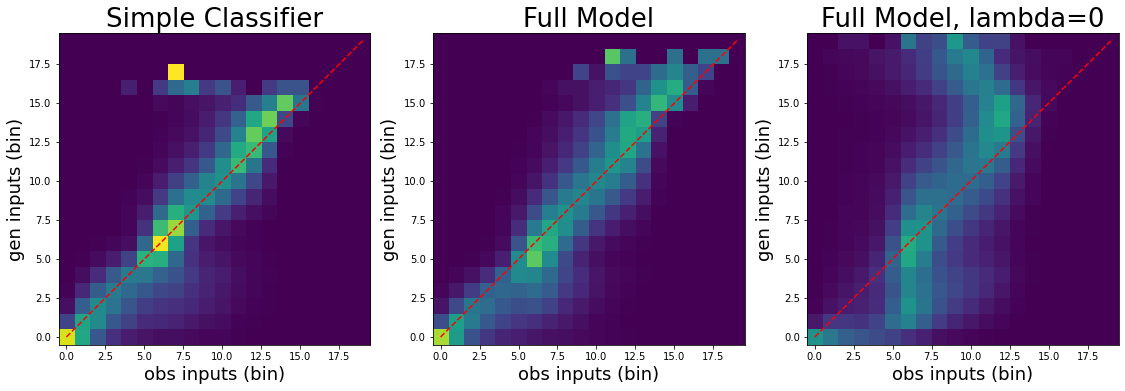

In [101]:
fig, ax = plt.subplots(1,3,figsize=(19,9))

ax[0].imshow(response_data_simple_swapped,
          origin='lower', 
             vmin=0., vmax=0.45,
          #norm=mpl.colors.LogNorm()
         )

ax[1].imshow(response_data_full_swapped,
          origin='lower',
             vmin=0., vmax=0.45,
          #norm=mpl.colors.LogNorm()
         )

ax[2].imshow(response_data_full_lam0_swapped,
          origin='lower',
             vmin=0., vmax=0.45,
          #norm=mpl.colors.LogNorm()
         )

ax[0].set_title('Simple Classifier', fontsize=26)
ax[1].set_title('Full Model', fontsize=26)
ax[2].set_title('Full Model, lambda=0', fontsize=26)

ax[0].plot([0,19],[0,19], ls='--', color='red')
ax[1].plot([0,19],[0,19], ls='--', color='red')
ax[2].plot([0,19],[0,19], ls='--', color='red')


ax[0].set_xlabel('obs inputs (bin)', fontsize=18)
ax[1].set_xlabel('obs inputs (bin)', fontsize=18)
ax[2].set_xlabel('obs inputs (bin)', fontsize=18)


ax[0].set_ylabel('gen inputs (bin)', fontsize=18)
ax[1].set_ylabel('gen inputs (bin)', fontsize=18)
ax[2].set_ylabel('gen inputs (bin)', fontsize=18)

plt.show()

In [102]:
len(hist_simple[1])

21

In [103]:

hist_data_simple = hist_simple[0]
hist_axis = hist_simple[1]
axis_values = np.zeros(len(hist_simple[0]))

for i in range(len(hist_data_simple)) :
    for j in range(len(hist_data_simple[i])) :
        x = 0.5 * (hist_axis[i] + hist_axis[i+1])
        axis_values[i] = x


In [104]:
len(axis_values)

20

In [105]:
axis_values

array([0.02375, 0.07125, 0.11875, 0.16625, 0.21375, 0.26125, 0.30875,
       0.35625, 0.40375, 0.45125, 0.49875, 0.54625, 0.59375, 0.64125,
       0.68875, 0.73625, 0.78375, 0.83125, 0.87875, 0.92625])

In [106]:
hist_simple[1]

array([0.    , 0.0475, 0.095 , 0.1425, 0.19  , 0.2375, 0.285 , 0.3325,
       0.38  , 0.4275, 0.475 , 0.5225, 0.57  , 0.6175, 0.665 , 0.7125,
       0.76  , 0.8075, 0.855 , 0.9025, 0.95  ])

In [107]:
hist_simple_obs[1]

array([0.    , 0.0475, 0.095 , 0.1425, 0.19  , 0.2375, 0.285 , 0.3325,
       0.38  , 0.4275, 0.475 , 0.5225, 0.57  , 0.6175, 0.665 , 0.7125,
       0.76  , 0.8075, 0.855 , 0.9025, 0.95  ], dtype=float32)

In [108]:
hist_simple_obs[0]

array([1.609000e+03, 4.212000e+03, 8.832000e+03, 1.743400e+04,
       4.134000e+04, 2.357180e+05, 9.306320e+05, 1.386828e+06,
       1.258294e+06, 1.414115e+06, 1.814410e+06, 2.314480e+06,
       2.190467e+06, 1.099849e+06, 4.646900e+04, 1.083000e+03,
       1.000000e+01, 0.000000e+00, 0.000000e+00, 0.000000e+00])

In [109]:
hist_simple_gen[0]

array([2.292000e+03, 4.360000e+03, 6.773000e+03, 1.143600e+04,
       2.092200e+04, 6.937800e+04, 3.459880e+05, 1.203078e+06,
       1.161215e+06, 1.216450e+06, 1.561817e+06, 2.364931e+06,
       2.637292e+06, 2.093872e+06, 6.509900e+04, 8.500000e+02,
       2.600000e+01, 3.000000e+00, 0.000000e+00, 0.000000e+00])

In [110]:
np.sum(hist_simple[0],axis=0)

array([2.292000e+03, 4.360000e+03, 6.773000e+03, 1.143600e+04,
       2.092200e+04, 6.937800e+04, 3.459880e+05, 1.203079e+06,
       1.161214e+06, 1.216450e+06, 1.561819e+06, 2.364932e+06,
       2.637289e+06, 2.093872e+06, 6.509900e+04, 8.500000e+02,
       2.600000e+01, 3.000000e+00, 0.000000e+00, 0.000000e+00])

In [111]:
np.sum(hist_simple[0],axis=1)

array([1.609000e+03, 4.212000e+03, 8.832000e+03, 1.743400e+04,
       4.134000e+04, 2.357190e+05, 9.306310e+05, 1.386829e+06,
       1.258293e+06, 1.414116e+06, 1.814411e+06, 2.314482e+06,
       2.190463e+06, 1.099849e+06, 4.646900e+04, 1.083000e+03,
       1.000000e+01, 0.000000e+00, 0.000000e+00, 0.000000e+00])

In [112]:
np.sum(hist_simple_obs[0])

12765782.0

In [113]:
np.sum(hist_simple_gen[0])

12765782.0

In [114]:
np.sum(np.sum(hist_simple[0],axis=0))

12765782.0

In [115]:
np.sum(np.sum(hist_simple[0],axis=1))

12765782.0

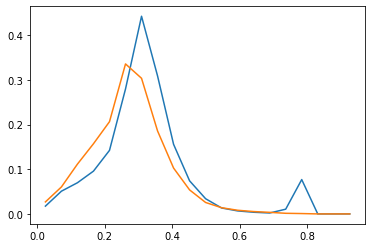

In [116]:
plt.plot(axis_values,response_data_simple[6])
plt.plot(axis_values,response_data_full[6])


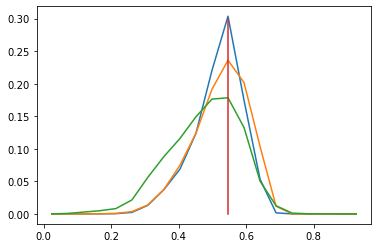

In [117]:
bin = 11
plt.plot(axis_values,response_data_simple_swapped[bin])
plt.plot(axis_values,response_data_full_swapped[bin])
plt.plot(axis_values,response_data_full_lam0_swapped[bin])
plt.plot([axis_values[bin],axis_values[bin]],[0,0.3])

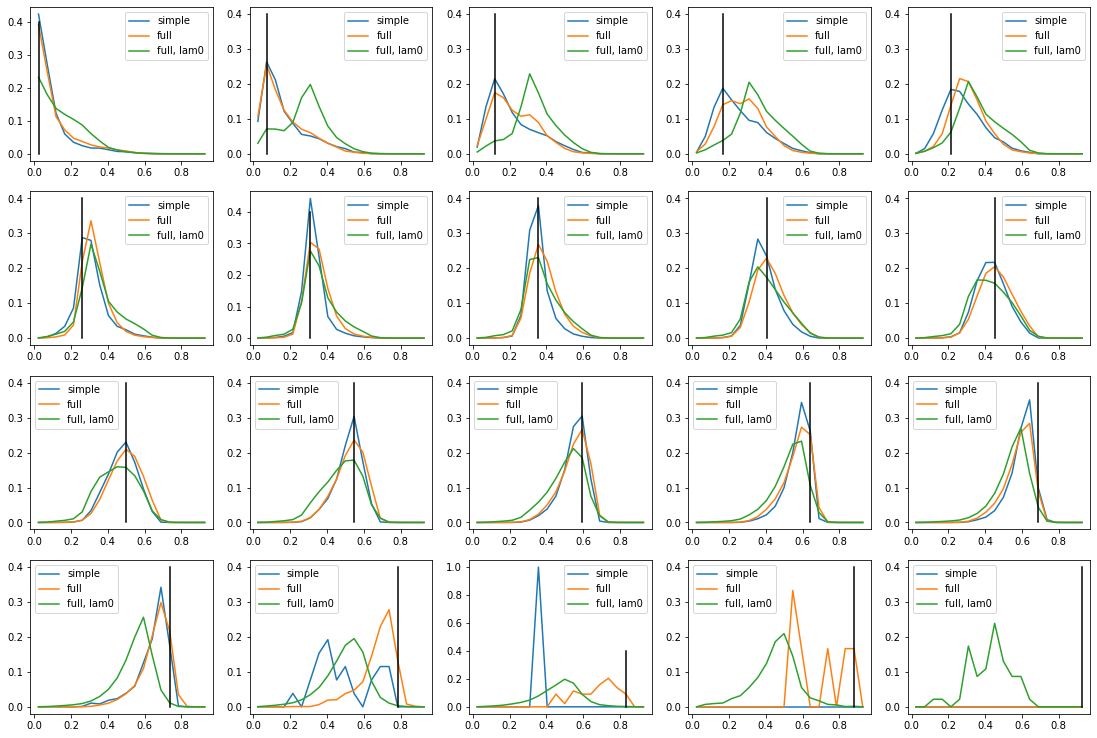

In [118]:
fig, ax = plt.subplots(4,5,figsize=(19,13))

axf = ax.flatten()

for bin in range( len(axis_values)) :
    axf[bin].plot(axis_values,response_data_simple_swapped[bin],label='simple')
    axf[bin].plot(axis_values,response_data_full_swapped[bin],label='full')
    axf[bin].plot(axis_values,response_data_full_lam0_swapped[bin],label='full, lam0')
    axf[bin].plot([axis_values[bin],axis_values[bin]],[0,0.4], color='black')    
    axf[bin].legend( loc='best')
    
    

In [119]:
ax

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

## Sanity check :  Train a simple classifier with the same input as above (mix of particle and detector level events).

In [120]:
model_sc = Sequential()
model_sc.add(Dense(50, input_dim=9, activation='relu')) 
model_sc.add(Dense(50, activation='relu'))
model_sc.add(Dense(1, activation='sigmoid'))

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )

if use_weights :

    print("Training with weights.")
    
    model_sc.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'], 
                     weighted_metrics=['accuracy'])

else :

    model_sc.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
    

In [121]:
%%time

if run_training:
    
    if use_weights :

        hist_sc = model_sc.fit(X_gen_and_obs_train, Y_gen_and_obs_train, sample_weight = w_gen_and_obs_train,
                       validation_data=(X_gen_and_obs_test, Y_gen_and_obs_test, w_gen_and_obs_test), 
                       epochs=max_epochs, batch_size=batch_size_setval, verbose = 1, callbacks=[earlystopping] )
 
        
        
    else :
        
        hist_sc = model_sc.fit(X_gen_and_obs_train, Y_gen_and_obs_train, 
                       validation_data=(X_gen_and_obs_test, Y_gen_and_obs_test), 
                       epochs=max_epochs, batch_size=batch_size_setval, verbose = 1, callbacks=[earlystopping] )
        
        
        

Epoch 1/5000
49867/49867 [==============================] - 171s 3ms/step - loss: 0.6684 - accuracy: 0.5934 - val_loss: 0.6655 - val_accuracy: 0.5981
Epoch 2/5000
49867/49867 [==============================] - 160s 3ms/step - loss: 0.6642 - accuracy: 0.5998 - val_loss: 0.6631 - val_accuracy: 0.6011
Epoch 3/5000
49867/49867 [==============================] - 167s 3ms/step - loss: 0.6623 - accuracy: 0.6023 - val_loss: 0.6615 - val_accuracy: 0.6036
Epoch 4/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6611 - accuracy: 0.6043 - val_loss: 0.6607 - val_accuracy: 0.6049
Epoch 5/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6604 - accuracy: 0.6053 - val_loss: 0.6601 - val_accuracy: 0.6061
Epoch 6/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6599 - accuracy: 0.6061 - val_loss: 0.6598 - val_accuracy: 0.6066
Epoch 7/5000
49867/49867 [==============================] - 170s 3ms/step - loss: 0.6596 - accuracy:

49867/49867 [==============================] - 170s 3ms/step - loss: 0.6559 - accuracy: 0.6129 - val_loss: 0.6560 - val_accuracy: 0.6126
Epoch 56/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6558 - accuracy: 0.6131 - val_loss: 0.6557 - val_accuracy: 0.6132
Epoch 57/5000
49867/49867 [==============================] - 164s 3ms/step - loss: 0.6557 - accuracy: 0.6132 - val_loss: 0.6556 - val_accuracy: 0.6133
Epoch 58/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6556 - accuracy: 0.6133 - val_loss: 0.6556 - val_accuracy: 0.6132
Epoch 59/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6554 - accuracy: 0.6134 - val_loss: 0.6554 - val_accuracy: 0.6136
Epoch 60/5000
49867/49867 [==============================] - 167s 3ms/step - loss: 0.6553 - accuracy: 0.6136 - val_loss: 0.6553 - val_accuracy: 0.6137
Epoch 61/5000
49867/49867 [==============================] - 167s 3ms/step - loss: 0.6552 - accuracy: 0.6137

49867/49867 [==============================] - 164s 3ms/step - loss: 0.6496 - accuracy: 0.6181 - val_loss: 0.6496 - val_accuracy: 0.6180
Epoch 110/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6496 - accuracy: 0.6182 - val_loss: 0.6496 - val_accuracy: 0.6183
Epoch 111/5000
49867/49867 [==============================] - 167s 3ms/step - loss: 0.6495 - accuracy: 0.6182 - val_loss: 0.6494 - val_accuracy: 0.6184
Epoch 112/5000
49867/49867 [==============================] - 166s 3ms/step - loss: 0.6495 - accuracy: 0.6182 - val_loss: 0.6495 - val_accuracy: 0.6179
Epoch 113/5000
49867/49867 [==============================] - 167s 3ms/step - loss: 0.6494 - accuracy: 0.6183 - val_loss: 0.6493 - val_accuracy: 0.6184
Epoch 114/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6493 - accuracy: 0.6183 - val_loss: 0.6493 - val_accuracy: 0.6184
Epoch 115/5000
49867/49867 [==============================] - 167s 3ms/step - loss: 0.6493 - accuracy: 

Epoch 163/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6476 - accuracy: 0.6196 - val_loss: 0.6474 - val_accuracy: 0.6197
Epoch 164/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6476 - accuracy: 0.6196 - val_loss: 0.6475 - val_accuracy: 0.6198
Epoch 165/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6476 - accuracy: 0.6196 - val_loss: 0.6477 - val_accuracy: 0.6196
Epoch 166/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6476 - accuracy: 0.6196 - val_loss: 0.6477 - val_accuracy: 0.6195
Epoch 167/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6475 - accuracy: 0.6196 - val_loss: 0.6475 - val_accuracy: 0.6197
Epoch 168/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6475 - accuracy: 0.6196 - val_loss: 0.6476 - val_accuracy: 0.6197
Epoch 169/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.64

Epoch 217/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6466 - accuracy: 0.6203 - val_loss: 0.6466 - val_accuracy: 0.6205
Epoch 218/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6466 - accuracy: 0.6203 - val_loss: 0.6464 - val_accuracy: 0.6206
Epoch 219/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6466 - accuracy: 0.6203 - val_loss: 0.6470 - val_accuracy: 0.6200
Epoch 220/5000
49867/49867 [==============================] - 166s 3ms/step - loss: 0.6466 - accuracy: 0.6204 - val_loss: 0.6474 - val_accuracy: 0.6201
Epoch 221/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6466 - accuracy: 0.6203 - val_loss: 0.6467 - val_accuracy: 0.6203
Epoch 222/5000
49867/49867 [==============================] - 167s 3ms/step - loss: 0.6466 - accuracy: 0.6203 - val_loss: 0.6468 - val_accuracy: 0.6202
Epoch 223/5000
49867/49867 [==============================] - 165s 3ms/step - loss: 0.64

Epoch 271/5000
49867/49867 [==============================] - 159s 3ms/step - loss: 0.6460 - accuracy: 0.6208 - val_loss: 0.6460 - val_accuracy: 0.6208
Epoch 272/5000
49867/49867 [==============================] - 167s 3ms/step - loss: 0.6460 - accuracy: 0.6209 - val_loss: 0.6458 - val_accuracy: 0.6211
Epoch 273/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6460 - accuracy: 0.6208 - val_loss: 0.6461 - val_accuracy: 0.6211
Epoch 274/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6460 - accuracy: 0.6209 - val_loss: 0.6460 - val_accuracy: 0.6210
Epoch 275/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6460 - accuracy: 0.6208 - val_loss: 0.6461 - val_accuracy: 0.6210
Epoch 276/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6460 - accuracy: 0.6209 - val_loss: 0.6463 - val_accuracy: 0.6209
Epoch 277/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.64

Epoch 325/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6457 - accuracy: 0.6212 - val_loss: 0.6454 - val_accuracy: 0.6215
Epoch 326/5000
49867/49867 [==============================] - 167s 3ms/step - loss: 0.6456 - accuracy: 0.6212 - val_loss: 0.6456 - val_accuracy: 0.6211
Epoch 327/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6456 - accuracy: 0.6212 - val_loss: 0.6454 - val_accuracy: 0.6213
Epoch 328/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6456 - accuracy: 0.6213 - val_loss: 0.6457 - val_accuracy: 0.6211
Epoch 329/5000
49867/49867 [==============================] - 170s 3ms/step - loss: 0.6456 - accuracy: 0.6212 - val_loss: 0.6456 - val_accuracy: 0.6214
Epoch 330/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6456 - accuracy: 0.6213 - val_loss: 0.6458 - val_accuracy: 0.6211
Epoch 331/5000
49867/49867 [==============================] - 163s 3ms/step - loss: 0.64

Epoch 379/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6454 - accuracy: 0.6215 - val_loss: 0.6452 - val_accuracy: 0.6216
Epoch 380/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6454 - accuracy: 0.6214 - val_loss: 0.6450 - val_accuracy: 0.6218
Epoch 381/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6454 - accuracy: 0.6215 - val_loss: 0.6465 - val_accuracy: 0.6208
Epoch 382/5000
49867/49867 [==============================] - 169s 3ms/step - loss: 0.6453 - accuracy: 0.6215 - val_loss: 0.6451 - val_accuracy: 0.6216
Epoch 383/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.6454 - accuracy: 0.6215 - val_loss: 0.6450 - val_accuracy: 0.6217
Epoch 384/5000
49867/49867 [==============================] - 170s 3ms/step - loss: 0.6454 - accuracy: 0.6214 - val_loss: 0.6453 - val_accuracy: 0.6216
Epoch 385/5000
49867/49867 [==============================] - 168s 3ms/step - loss: 0.64

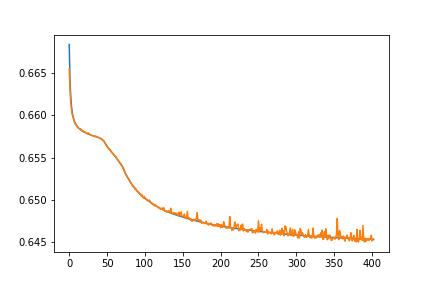

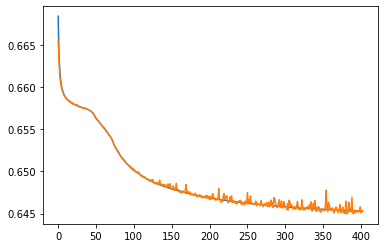

In [122]:
if run_training :
    plt.plot(hist_sc.history['loss'])
    plt.plot(hist_sc.history['val_loss'])
    plt.savefig('%s/loss-vs-epoch-standalone-classifier-gen-and-obs-inputs.pdf' % output_dir )
    plt.savefig('%s/loss-vs-epoch-standalone-classifier-gen-and-obs-inputs.png' % output_dir )

display.Image('%s/loss-vs-epoch-standalone-classifier-gen-and-obs-inputs.png' % output_dir )

In [123]:
if run_training :
    tf.keras.models.save_model( model_sc, '%s/model-standalone-classifier-gen-and-obs-inputs' % output_dir )
else :
    model_sc = tf.keras.models.load_model( '%s/model-standalone-classifier-gen-and-obs-inputs' % output_dir )

INFO:tensorflow:Assets written to: version5a-lambda1.00-no-weights-training-output/model-standalone-classifier-gen-and-obs-inputs/assets


In [124]:
classifier_output_django_gen_sc = model_sc.predict( Xs_gen_d, batch_size=2048 )
classifier_output_django_obs_sc = model_sc.predict( Xs_obs_d, batch_size=2048 )
classifier_output_rapgap_gen_sc = model_sc.predict( Xs_gen_r, batch_size=2048 )
classifier_output_rapgap_obs_sc = model_sc.predict( Xs_obs_r, batch_size=2048 )

6068/6068 [==============================] - 4s 576us/step


Turning off weights.


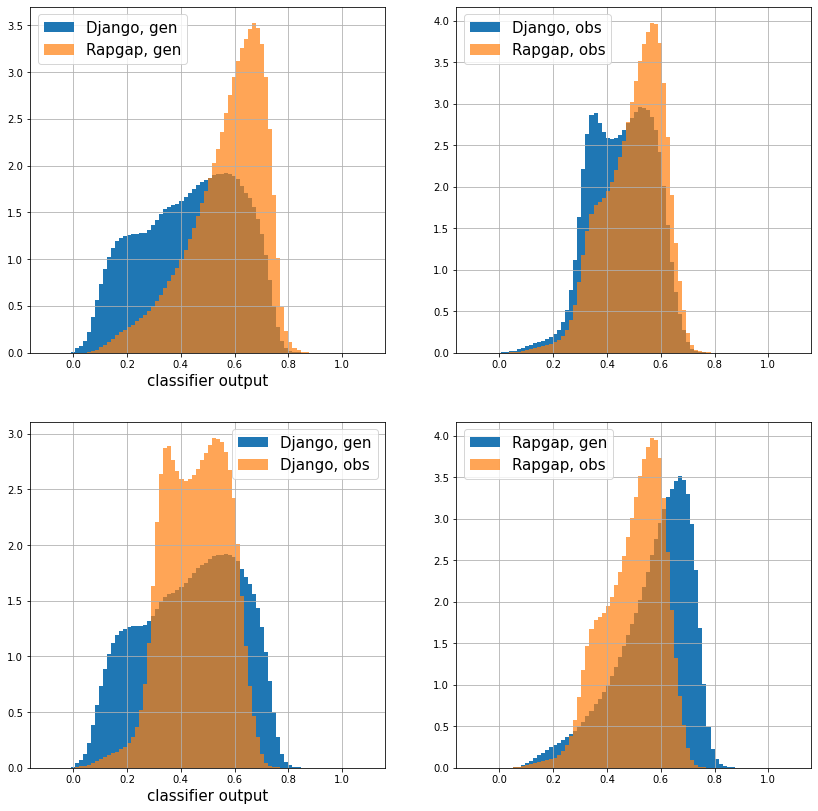

In [125]:
fig,ax = plt.subplots(2,2,figsize=(14,14))

hweights_r = w_r
hweights_d = w_d

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights_r.fill(1)
    hweights_d.fill(1)



ax[0][0].hist( classifier_output_django_gen_sc, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[0][0].hist( classifier_output_rapgap_gen_sc, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen', alpha=0.7)
    
ax[0][1].hist( classifier_output_django_obs_sc, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs' )
ax[0][1].hist( classifier_output_rapgap_obs_sc, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7)

ax[1][0].hist( classifier_output_django_gen_sc, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[1][0].hist( classifier_output_django_obs_sc, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs', alpha=0.7 )

ax[1][1].hist( classifier_output_rapgap_gen_sc, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen' )
ax[1][1].hist( classifier_output_rapgap_obs_sc, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7 )




ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()



hfontsize=15

ax[0][0].set_xlabel('classifier output', fontsize=hfontsize)
ax[1][0].set_xlabel('classifier output', fontsize=hfontsize)




ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)


plt.show()

## Try and set up a classifier that takes a single input, which is the output of the Django vs Rapgap classifier

In [126]:
model_adv_standalone = Sequential()
model_adv_standalone.add(Dense(50, input_dim=1, activation='relu')) 
model_adv_standalone.add(Dense(50, activation='relu'))
model_adv_standalone.add(Dense(50, activation='relu'))
model_adv_standalone.add(Dense(50, activation='relu'))
model_adv_standalone.add(Dense(50, activation='relu'))
model_adv_standalone.add(Dense(1, activation='sigmoid'))

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )

if use_weights :

    model_adv_standalone.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'],
                                weighted_metrics=['accuracy'])
    
else :
    
    model_adv_standalone.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
    

In [127]:
X_adv_standalone_train = model_sc.predict( X_gen_and_obs_train, batch_size=2048 )
X_adv_standalone_test = model_sc.predict( X_gen_and_obs_test, batch_size=2048 )

12467/12467 [==============================] - 7s 583us/step


In [128]:
%%time

if run_training :
    
    if use_weights :
        
        hist_adv_standalone = model_adv_standalone.fit(X_adv_standalone_train, Z_gen_and_obs_train,
                                    sample_weight=w_gen_and_obs_train,
                                    validation_data=(X_adv_standalone_test, Z_gen_and_obs_test, w_gen_and_obs_test),
                                    epochs=max_epochs, batch_size=batch_size_setval,
                                    verbose = 1, callbacks=[earlystopping] )
        
    else :
        
        hist_adv_standalone = model_adv_standalone.fit(X_adv_standalone_train, Z_gen_and_obs_train, 
                                               validation_data=(X_adv_standalone_test, Z_gen_and_obs_test),
                                               epochs=max_epochs, batch_size=batch_size_setval,
                                               verbose = 1, callbacks=[earlystopping] )

Epoch 1/5000
49867/49867 [==============================] - 206s 4ms/step - loss: 0.6083 - accuracy: 0.6586 - val_loss: 0.6063 - val_accuracy: 0.6606
Epoch 2/5000
49867/49867 [==============================] - 205s 4ms/step - loss: 0.6063 - accuracy: 0.6606 - val_loss: 0.6063 - val_accuracy: 0.6606
Epoch 3/5000
49867/49867 [==============================] - 207s 4ms/step - loss: 0.6063 - accuracy: 0.6606 - val_loss: 0.6064 - val_accuracy: 0.6605
Epoch 4/5000
49867/49867 [==============================] - 203s 4ms/step - loss: 0.6063 - accuracy: 0.6606 - val_loss: 0.6066 - val_accuracy: 0.6604
Epoch 5/5000
49867/49867 [==============================] - 202s 4ms/step - loss: 0.6063 - accuracy: 0.6606 - val_loss: 0.6063 - val_accuracy: 0.6605
Epoch 6/5000
49867/49867 [==============================] - 204s 4ms/step - loss: 0.6063 - accuracy: 0.6606 - val_loss: 0.6065 - val_accuracy: 0.6606
Epoch 7/5000
49867/49867 [==============================] - 207s 4ms/step - loss: 0.6062 - accuracy:

49867/49867 [==============================] - 208s 4ms/step - loss: 0.6062 - accuracy: 0.6607 - val_loss: 0.6063 - val_accuracy: 0.6606
Epoch 56/5000
49867/49867 [==============================] - 205s 4ms/step - loss: 0.6062 - accuracy: 0.6607 - val_loss: 0.6063 - val_accuracy: 0.6606
Epoch 57/5000
49867/49867 [==============================] - 206s 4ms/step - loss: 0.6062 - accuracy: 0.6607 - val_loss: 0.6062 - val_accuracy: 0.6606
Epoch 57: early stopping
CPU times: user 4h 32min 20s, sys: 14min 36s, total: 4h 46min 56s
Wall time: 3h 15min 35s


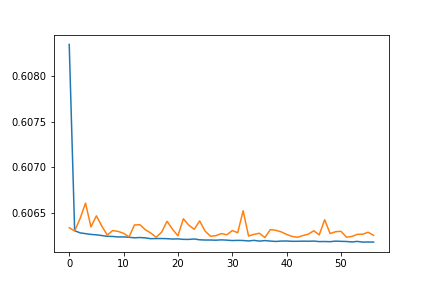

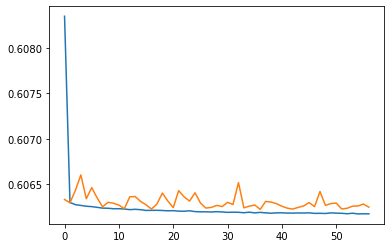

In [129]:
if run_training :
    plt.plot(hist_adv_standalone.history['loss'])
    plt.plot(hist_adv_standalone.history['val_loss'])
    plt.savefig('%s/loss-vs-epoch-standalone-adversary-gen-and-obs-inputs-no-labels.pdf' % output_dir )
    plt.savefig('%s/loss-vs-epoch-standalone-adversary-gen-and-obs-inputs-no-labels.png' % output_dir )

display.Image('%s/loss-vs-epoch-standalone-adversary-gen-and-obs-inputs-no-labels.png' % output_dir )

In [130]:
if run_training :
    tf.keras.models.save_model( model_adv_standalone, 
                           '%s/model-standalone-adversary-gen-and-obs-inputs-no-labels' % output_dir )
else :
    model_adv_standalone = tf.keras.models.load_model(
                           '%s/model-standalone-adversary-gen-and-obs-inputs-no-labels' % output_dir )    

INFO:tensorflow:Assets written to: version5a-lambda1.00-no-weights-training-output/model-standalone-adversary-gen-and-obs-inputs-no-labels/assets


In [131]:
adv_pred = model_adv_standalone.predict( X_adv_standalone_test, batch_size=2048 )

12467/12467 [==============================] - 12s 945us/step


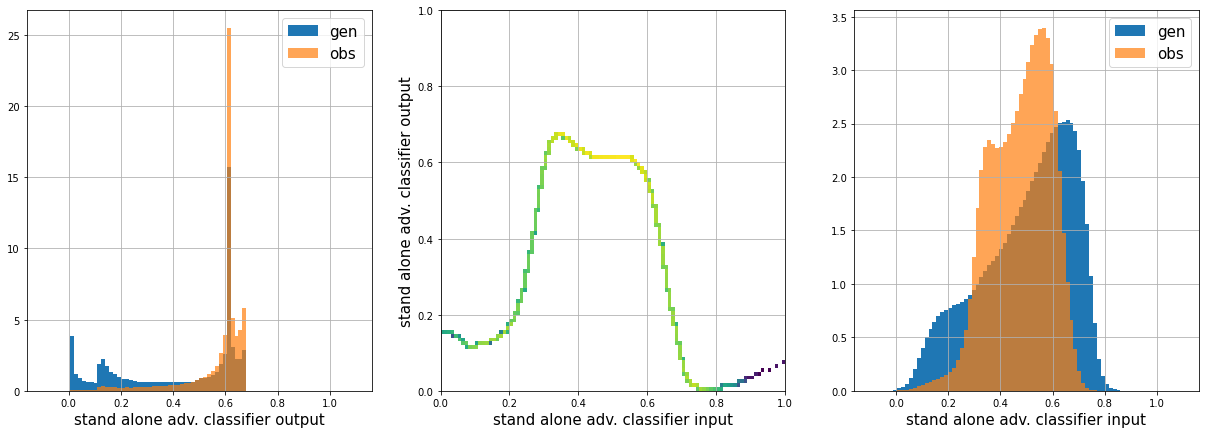

In [132]:
fig,ax = plt.subplots(1,3,figsize=(21,7))


hweights = w_gen_and_obs_test
    
if use_weights :
    print("Using weights.")
else :
    hweights.fill( 1. )
    
    

ax[0].hist( adv_pred[Z_gen_and_obs_test==0], weights=hweights[Z_gen_and_obs_test==0],
           density=True, bins=80, range=[-0.1,1.1], label='gen' )
ax[0].hist( adv_pred[Z_gen_and_obs_test==1], weights=hweights[Z_gen_and_obs_test==1],
           density=True, bins=80, range=[-0.1,1.1], label='obs', alpha=0.7)

ax[1].hist2d( X_adv_standalone_test[:,0], adv_pred[:,0], weights=hweights[:,0],
             bins=100, range=([0,1],[0,1]), norm=mpl.colors.LogNorm()  )

ax[2].hist( X_adv_standalone_test[Z_gen_and_obs_test==0], weights=hweights[Z_gen_and_obs_test==0],
           bins=80, range=[-0.1,1.1], label='gen', density=True )
ax[2].hist( X_adv_standalone_test[Z_gen_and_obs_test==1], weights=hweights[Z_gen_and_obs_test==1],
           bins=80, range=[-0.1,1.1], label='obs', density=True, alpha=0.7 )

ax[0].grid()
ax[1].grid()
ax[2].grid()



hfontsize=15

ax[0].set_xlabel('stand alone adv. classifier output', fontsize=hfontsize)

ax[1].set_xlabel('stand alone adv. classifier input', fontsize=hfontsize)
ax[1].set_ylabel('stand alone adv. classifier output', fontsize=hfontsize)

ax[2].set_xlabel('stand alone adv. classifier input', fontsize=hfontsize)


ax[0].legend( loc='best', fontsize=hfontsize)
ax[2].legend( loc='best', fontsize=hfontsize)


plt.show()

## Now try training the adversary part in the same way, providing the first NN output and the Y labels for the first NN as inputs to the adversary network

In [133]:
np.shape(X_gen_and_obs_train)

(25531563, 9)

In [134]:
X_adv_standalone2_train = np.concatenate([X_adv_standalone_train, Y_gen_and_obs_train],axis=1 )
X_adv_standalone2_test = np.concatenate([X_adv_standalone_test, Y_gen_and_obs_test],axis=1 )

In [135]:
X_adv_standalone2_train

array([[0.49351025, 0.        ],
       [0.6279375 , 1.        ],
       [0.08448236, 0.        ],
       ...,
       [0.42982802, 0.        ],
       [0.29452634, 0.        ],
       [0.51247454, 0.        ]])

In [136]:
for i in range(20):
    print("  %.4f  %.1f" % (X_adv_standalone2_train[i,0], X_adv_standalone2_train[i,1]))

  0.4935  0.0
  0.6279  1.0
  0.0845  0.0
  0.4546  0.0
  0.5142  0.0
  0.3892  0.0
  0.3581  0.0
  0.5758  1.0
  0.4721  1.0
  0.6048  1.0
  0.8057  1.0
  0.5493  1.0
  0.6574  0.0
  0.5225  0.0
  0.4879  1.0
  0.3645  1.0
  0.3822  1.0
  0.7892  1.0
  0.6304  1.0
  0.5578  0.0


In [137]:
model_adv_standalone2 = Sequential()
model_adv_standalone2.add(Dense(50, input_dim=2, activation='relu')) 
model_adv_standalone2.add(Dense(50, activation='relu'))
model_adv_standalone2.add(Dense(50, activation='relu'))
model_adv_standalone2.add(Dense(50, activation='relu'))
model_adv_standalone2.add(Dense(50, activation='relu'))
model_adv_standalone2.add(Dense(1, activation='sigmoid'))

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )


if use_weights :
    
    model_adv_standalone2.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'],
                                 weighted_metrics=['accuracy'])

else :
    
    model_adv_standalone2.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])

In [138]:
%%time

if run_training :
    
    if use_weights :

        hist_adv_standalone2 = model_adv_standalone2.fit(X_adv_standalone2_train, Z_gen_and_obs_train,
                                        sample_weight=w_gen_and_obs_train,
                                        validation_data=(X_adv_standalone2_test, Z_gen_and_obs_test, w_gen_and_obs_test),
                                        epochs=max_epochs, batch_size=batch_size_setval,
                                        verbose = 1, callbacks=[earlystopping] )
        
    else :
        
        hist_adv_standalone2 = model_adv_standalone2.fit(X_adv_standalone2_train, Z_gen_and_obs_train, 
                                               validation_data=(X_adv_standalone2_test, Z_gen_and_obs_test),
                                               epochs=max_epochs, batch_size=batch_size_setval,
                                               verbose = 1, callbacks=[earlystopping] )


Epoch 1/5000
49867/49867 [==============================] - 209s 4ms/step - loss: 0.6070 - accuracy: 0.6593 - val_loss: 0.6046 - val_accuracy: 0.6609
Epoch 2/5000
49867/49867 [==============================] - 205s 4ms/step - loss: 0.6047 - accuracy: 0.6609 - val_loss: 0.6046 - val_accuracy: 0.6609
Epoch 3/5000
49867/49867 [==============================] - 199s 4ms/step - loss: 0.6046 - accuracy: 0.6610 - val_loss: 0.6045 - val_accuracy: 0.6610
Epoch 4/5000
49867/49867 [==============================] - 204s 4ms/step - loss: 0.6046 - accuracy: 0.6610 - val_loss: 0.6046 - val_accuracy: 0.6609
Epoch 5/5000
49867/49867 [==============================] - 205s 4ms/step - loss: 0.6045 - accuracy: 0.6610 - val_loss: 0.6045 - val_accuracy: 0.6609
Epoch 6/5000
49867/49867 [==============================] - 206s 4ms/step - loss: 0.6045 - accuracy: 0.6610 - val_loss: 0.6044 - val_accuracy: 0.6610
Epoch 7/5000
49867/49867 [==============================] - 206s 4ms/step - loss: 0.6045 - accuracy:

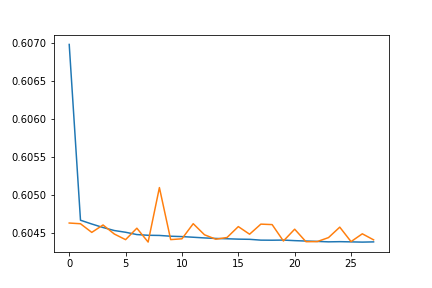

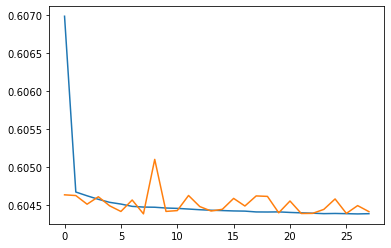

In [139]:
if run_training :
    plt.plot(hist_adv_standalone2.history['loss'])
    plt.plot(hist_adv_standalone2.history['val_loss'])
    plt.savefig('%s/loss-vs-epoch-standalone-adversary-gen-and-obs-inputs-with-labels.pdf' % output_dir )
    plt.savefig('%s/loss-vs-epoch-standalone-adversary-gen-and-obs-inputs-with-labels.png' % output_dir )

display.Image('%s/loss-vs-epoch-standalone-adversary-gen-and-obs-inputs-with-labels.png' % output_dir )

In [140]:
if run_training :
    tf.keras.models.save_model( model_adv_standalone2, 
                           '%s/model-standalone-adversary-gen-and-obs-inputs-with-labels' % output_dir )
else :
    model_adv_standalone2 = tf.keras.models.load_model(
                           '%s/model-standalone-adversary-gen-and-obs-inputs-with-labels' % output_dir )

INFO:tensorflow:Assets written to: version5a-lambda1.00-no-weights-training-output/model-standalone-adversary-gen-and-obs-inputs-with-labels/assets


In [141]:
adv2_pred = model_adv_standalone2.predict( X_adv_standalone2_test, batch_size=2048 )

12467/12467 [==============================] - 10s 776us/step


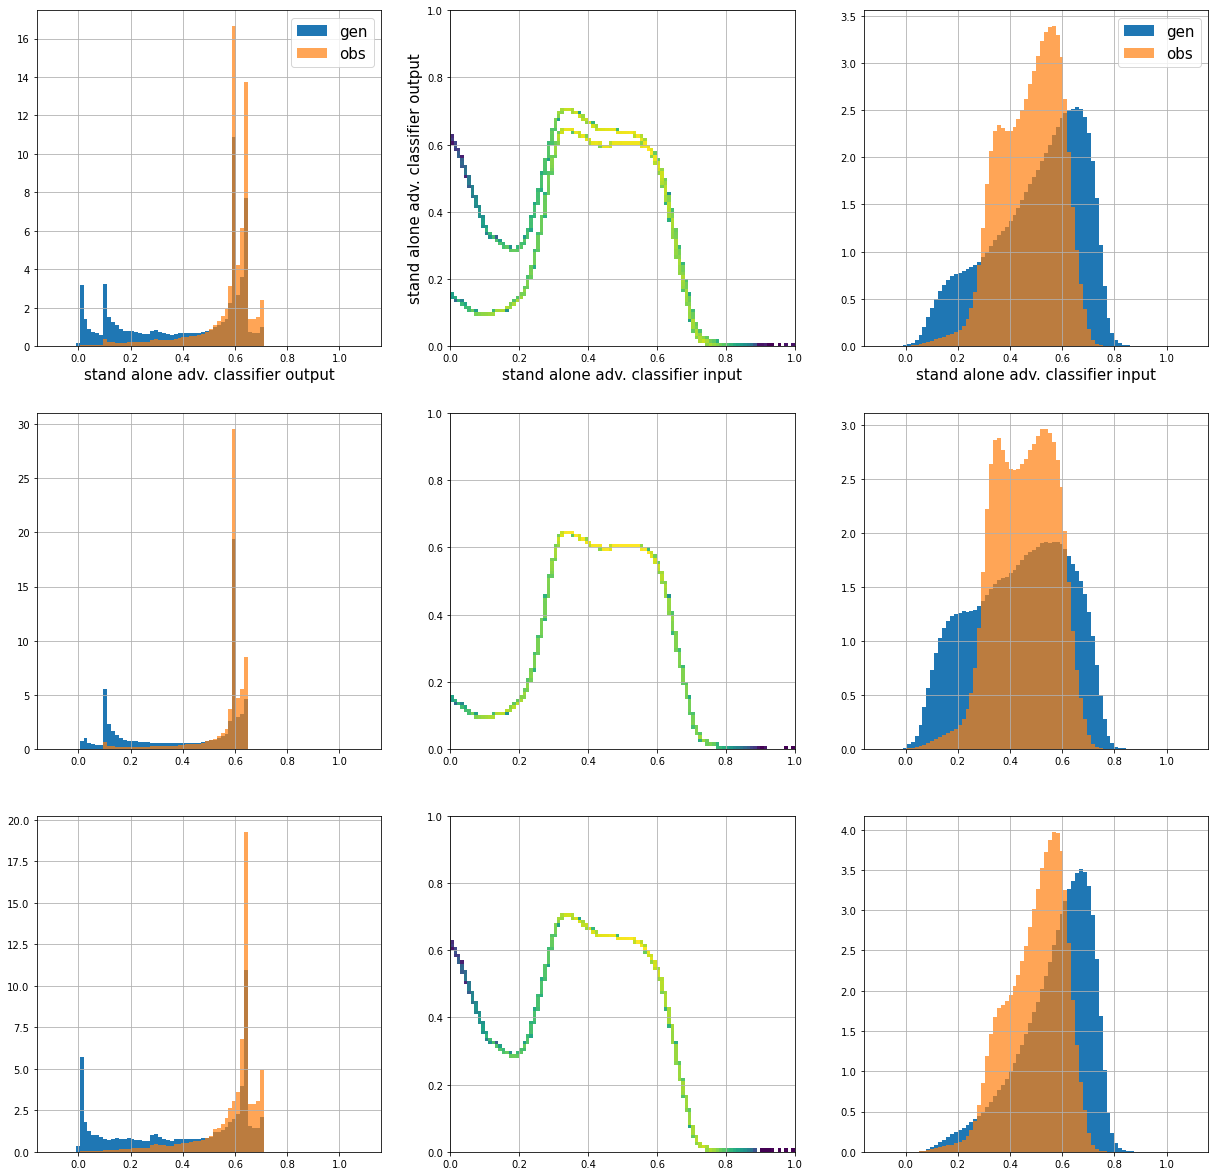

In [142]:
fig,ax = plt.subplots(3,3,figsize=(21,21))

hweights = w_gen_and_obs_test
    
if use_weights :
    print("Using weights.")
else :
    hweights.fill( 1. )
  


#-----------

ax[0][0].hist( adv2_pred[Z_gen_and_obs_test==0], weights=hweights[Z_gen_and_obs_test==0],
              density=True, bins=80, range=[-0.1,1.1], label='gen' )
ax[0][0].hist( adv2_pred[Z_gen_and_obs_test==1], weights=hweights[Z_gen_and_obs_test==1],
              density=True, bins=80, range=[-0.1,1.1], label='obs', alpha=0.7)

ax[0][1].hist2d( X_adv_standalone2_test[:,0], adv2_pred[:,0], weights=hweights[:,0],
                bins=100, range=([0,1],[0,1]), norm=mpl.colors.LogNorm()  )

ax[0][2].hist( X_adv_standalone2_test[Z_gen_and_obs_test==0][:,0], weights=hweights[Z_gen_and_obs_test==0][:,0],
              bins=80, range=[-0.1,1.1], label='gen', density=True )
ax[0][2].hist( X_adv_standalone2_test[Z_gen_and_obs_test==1][:,0], weights=hweights[Z_gen_and_obs_test==1][:,0],
              bins=80, range=[-0.1,1.1], label='obs', density=True, alpha=0.7 )

ax[0][0].grid()
ax[0][1].grid()
ax[0][2].grid()

#-----------


ax[1][0].hist( adv2_pred[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==0], 
              weights=hweights[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==0],
              density=True, bins=80, range=[-0.1,1.1], label='gen' )
ax[1][0].hist( adv2_pred[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==0],
              weights=hweights[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==0],
              density=True, bins=80, range=[-0.1,1.1], label='obs', alpha=0.7)

ax[1][1].hist2d( X_adv_standalone2_test[X_adv_standalone2_test[:,1]==0,0], 
                adv2_pred[X_adv_standalone2_test[:,1]==0,0], 
                weights=hweights[X_adv_standalone2_test[:,1]==0,0],
                bins=100, range=([0,1],[0,1]), norm=mpl.colors.LogNorm()  )

ax[1][2].hist( X_adv_standalone2_test[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==0][:,0], 
              weights=hweights[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==0][:,0], 
              bins=80, range=[-0.1,1.1], label='gen', density=True )
ax[1][2].hist( X_adv_standalone2_test[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==0][:,0], 
              weights=hweights[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==0][:,0], 
              bins=80, range=[-0.1,1.1], label='obs', density=True, alpha=0.7 )

ax[1][0].grid()
ax[1][1].grid()
ax[1][2].grid()

#-----------

ax[2][0].hist( adv2_pred[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==1], 
              weights=hweights[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==1],
              density=True, bins=80, range=[-0.1,1.1], label='gen' )
ax[2][0].hist( adv2_pred[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==1], 
              weights=hweights[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==1],
              density=True, bins=80, range=[-0.1,1.1], label='obs', alpha=0.7)


ax[2][1].hist2d( X_adv_standalone2_test[X_adv_standalone2_test[:,1]==1,0], adv2_pred[X_adv_standalone2_test[:,1]==1,0], 
                weights=hweights[X_adv_standalone2_test[:,1]==1,0], 
                bins=100, range=([0,1],[0,1]), norm=mpl.colors.LogNorm()  )

ax[2][2].hist( X_adv_standalone2_test[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==1][:,0], 
              weights=hweights[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==1][:,0],
              bins=80, range=[-0.1,1.1], label='gen', density=True )
ax[2][2].hist( X_adv_standalone2_test[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==1][:,0], 
              weights=hweights[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==1][:,0],
              bins=80, range=[-0.1,1.1], label='obs', density=True, alpha=0.7 )


ax[2][0].grid()
ax[2][1].grid()
ax[2][2].grid()


#-----------




hfontsize=15

ax[0][0].set_xlabel('stand alone adv. classifier output', fontsize=hfontsize)

ax[0][1].set_xlabel('stand alone adv. classifier input', fontsize=hfontsize)
ax[0][1].set_ylabel('stand alone adv. classifier output', fontsize=hfontsize)

ax[0][2].set_xlabel('stand alone adv. classifier input', fontsize=hfontsize)


ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[0][2].legend( loc='best', fontsize=hfontsize)


plt.show()